In [1]:
using DataFrames, CSV, DelimitedFiles, Statistics

CODE_ROOT = pwd()

JULIA_DATA_ROOT = CODE_ROOT * "/output"

FORTRAN_DATA_ROOT = CODE_ROOT * "/data/fortran-timing/"

include(CODE_ROOT * "/visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [2]:
# the maximum number of processes each mesh resolution was parallelized with
# each process should have at least 4 cells (nCellsX^2)/maxprocs[nCellsX] >= 4
# julia and fortran run with different limits due to slightly different mesh partitionings
maxprocs = Dict{Int64, Int64}(
    16 => 64,
    32 => 128,
    64 => 512,
    128 => 2048,
    256 => 4096,
    512 => 4096,
    )

ftmaxprocs = Dict{Int64, Int64}(
    16 => 64,
    32 => 256,
    64 => 256,
    128 => 4096,
    256 => 4096,
    512 => 4096,
    )
;

In [3]:
function latestfile(dir, filterfunc)
    fnames = filter(filterfunc, readdir(dir, join=true))
    @assert length(fnames) > 0 "no file in $dir matching pattern!"
    return fnames[end]
end

latestfile (generic function with 1 method)

In [4]:
function juliatimes(nCellsX, jprocs=4096)
    # read julia data from file
    fname = latestfile(JULIA_DATA_ROOT * "/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    df = DataFrame(CSV.File(fname))
    
    # get the simulation time and communication time columns, excluding the first one (this is usually slower from warm-up)
    simkeys = filter(col->startswith(col,"sim_time"), names(df))[2:end]
    mpikeys = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
    
    simtimes = Array(df[:,simkeys])
    mpitimes = Array(df[:,mpikeys])
    runtimes = simtimes + mpitimes
    
    juliarunmeans = dropdims( mean(runtimes, dims=2), dims=2)
    juliampimeans = dropdims( mean(mpitimes, dims=2), dims=2)
    
    juliarunminmax = permutedims(hcat(minimum(runtimes, dims=2), maximum(runtimes, dims=2)), (2,1))
    juliampiminmax = permutedims(hcat(minimum(mpitimes, dims=2), maximum(mpitimes, dims=2)), (2,1))
    
    return juliarunmeans, juliampimeans, df.procs, juliarunminmax, juliampiminmax, fname
end
function fortrantimes(nCellsX, fprocs=4096)

    # read fortran data from files
    fortranfnamerun = latestfile(FORTRAN_DATA_ROOT, x -> occursin("$(fprocs)pmax", x) && occursin("$(nCellsX)x$(nCellsX)", x) && x[end-3:end] == ".txt" && occursin("runtime", x))
    fortranfnamempi = latestfile(FORTRAN_DATA_ROOT, x -> occursin("$(fprocs)pmax", x) && occursin("$(nCellsX)x$(nCellsX)", x) && x[end-3:end] == ".txt" && occursin("halotime", x))
    fortranruntiming = readdlm(fortranfnamerun, skipstart=8)
    fortranmpitiming = readdlm(fortranfnamempi, skipstart=8)
    fortranrunmean = fortranruntiming[:,end]
    fortranmpimean = fortranmpitiming[:,end]
    fortranrunminmax = permutedims(hcat(minimum(fortranruntiming[:,2:end], dims=2), maximum(fortranruntiming[:,2:end], dims=2)), (2,1))
    fortranmpiminmax = permutedims(hcat(minimum(fortranmpitiming[:,2:end], dims=2), maximum(fortranmpitiming[:,2:end], dims=2)), (2,1))
    fortranprocs = fortranruntiming[:,1]
    
    return fortranrunmean, fortranmpimean, fortranprocs, fortranrunminmax, fortranmpiminmax, fortranfnamerun
end
function juliafortrantimesplits(nCellsX, jprocs=4096, fprocs=4096)
    juliarunmean, juliampimean, juliaprocs, juliarunminmax, juliampiminmax, juliafname = juliatimes(nCellsX, jprocs)
    fortranrunmean, fortranmpimean, fortranprocs, fortranrunminmax, fortranmpiminmax, fortranfnamerun = fortrantimes(nCellsX, fprocs)
    return juliarunmean, juliampimean, juliaprocs, fortranrunmean, fortranmpimean, fortranprocs, juliafname, fortranfnamerun, juliarunminmax, juliampiminmax, fortranrunminmax, fortranmpiminmax
end

juliafortrantimesplits (generic function with 3 methods)

In [5]:
linewidth = 1
linestyle = "-"
markersize = 10
tickfontsize = 15
labelfontsize = 22.5
titlefontsize = 25
blue = "blue"
red = "red"

"red"

In [10]:
function strongscalingplot(juliameans, juliaprocs, fortranmeans, fortranprocs, nCellsX, juliaerr=0, fortranerr=0; perfect=true)

    perfectjulia = juliameans[1] * juliaprocs[1] ./ juliaprocs
    
    fig, ax = plt.subplots(figsize=(9,9))
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.errorbar(juliaprocs, juliameans, yerr=juliaerr, label="Julia", linewidth=linewidth,linestyle="-",
                capsize=5, color=red,marker="s",markersize=markersize)
    ax.errorbar(fortranprocs, fortranmeans, yerr=fortranerr, label="Fortran", linewidth=linewidth,
                capsize=5, linestyle="--", color=blue,marker="D",markersize=markersize)
    if perfect
        ax.plot(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)
    end

    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
    ax.set_ylabel("Simulation time (s)", fontsize=labelfontsize, labelpad=10)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=titlefontsize, fontweight="bold", y=1.02)
    ax.legend(loc="upper right", fontsize=labelfontsize-2.5)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot (generic function with 3 methods)

In [12]:
savefigs=true

true

saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/total_output--kelvinwave--resolution16x16--procs64--steps10--nvlevels100--2023-06-17T14:58:54.906.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/calc_only_output--kelvinwave--resolution16x16--procs64--steps10--nvlevels100--2023-06-17T14:58:54.906.txt.pdf
16x16/procs64/steps10/nvlevels100/2023-06-17T14:58:54.906.txt
ng/runtime_perlmutter_64plane_64pmax_1pmin_16x16_20230619.txt
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/total_output--kelvinwave--resolution32x32--procs128--steps10--nvlevels100--2023-06-17T14:58:58.674.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/calc_only_output--kelvinwave--resolution32x32--procs128--steps10--nvlevels100--2023-06-17T14:58:58.674.txt.pdf
2x32/procs128/steps10/nvlevels100/2023-06-17T14:58:58.674.txt
g/runtime_perlmutter_32plane_256pmax_1pmin_32x32_20230528.txt
saved at /global/u

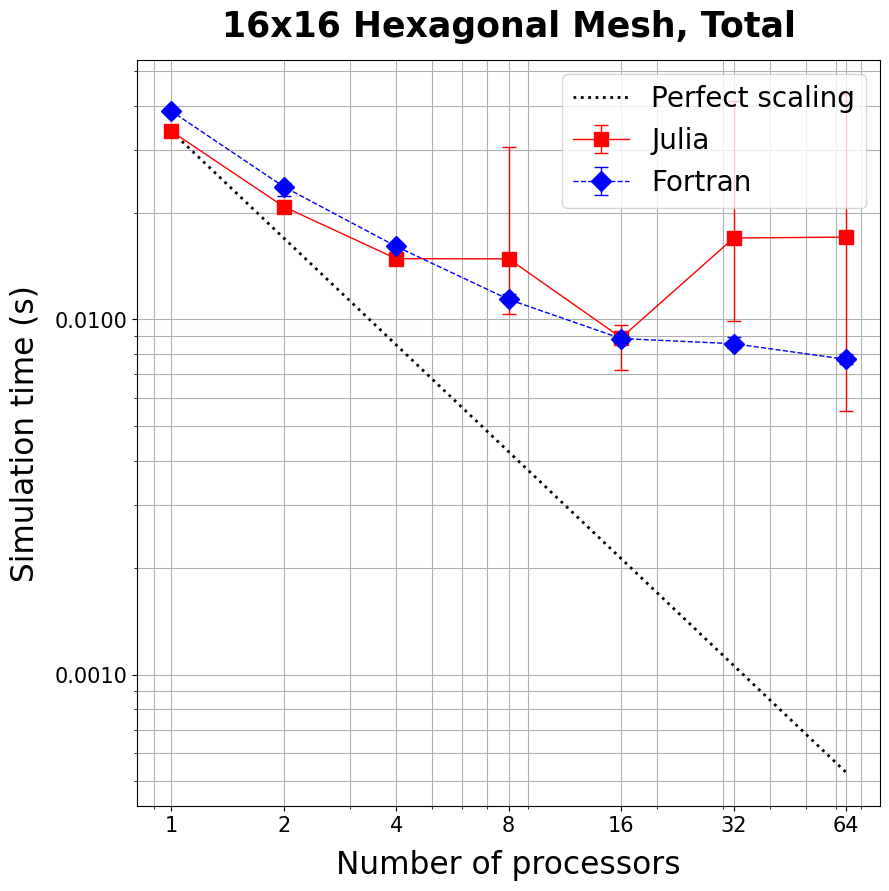

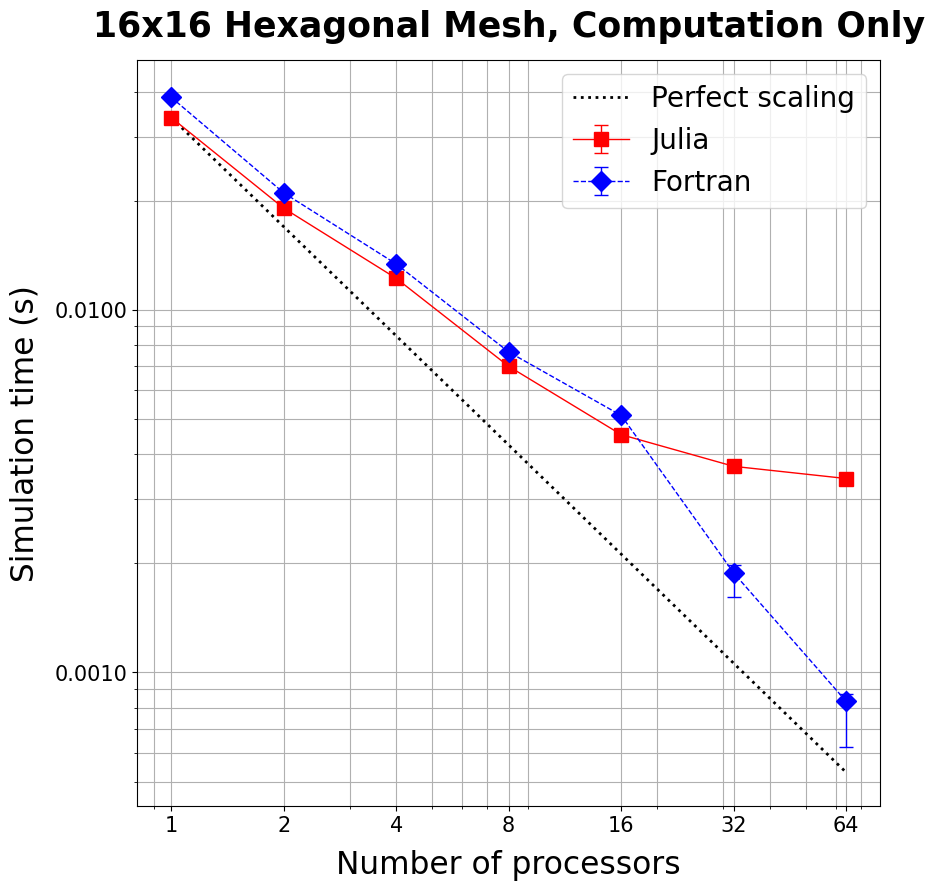

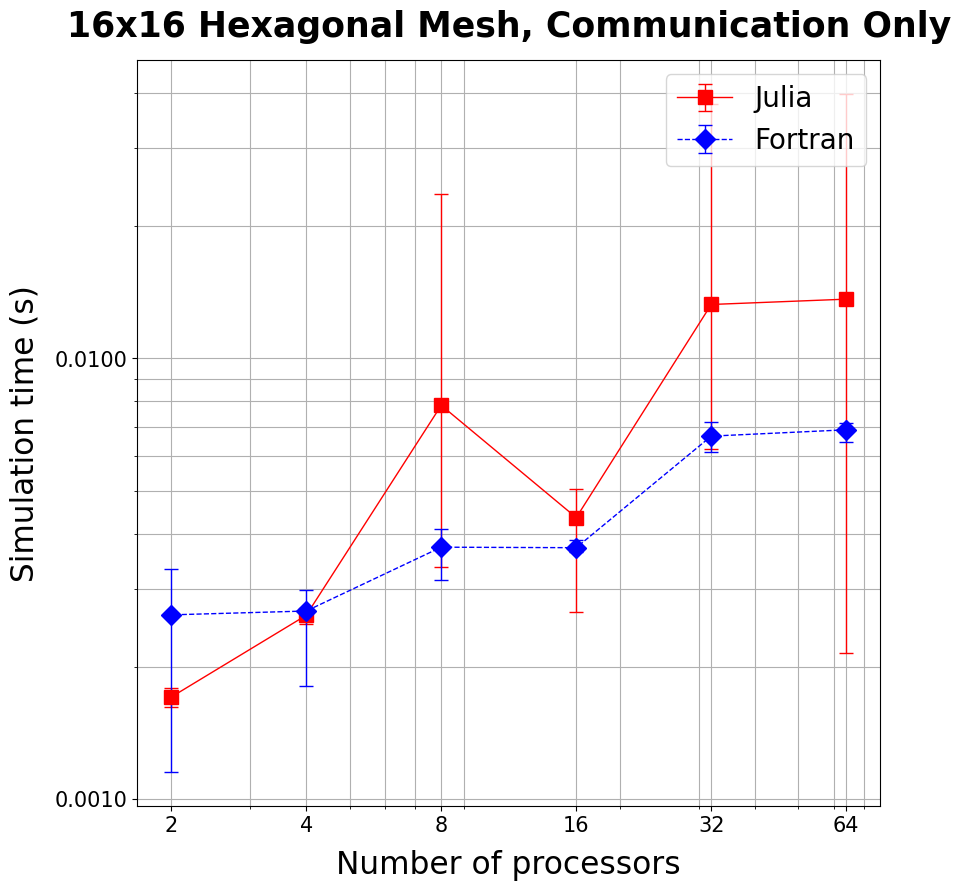

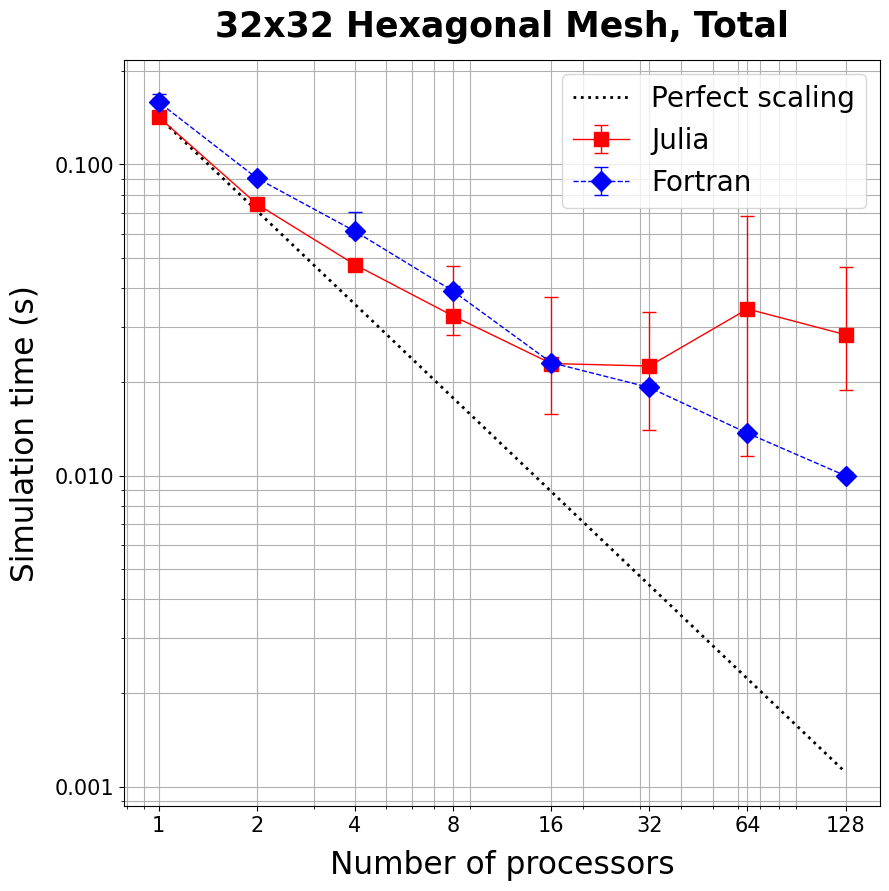

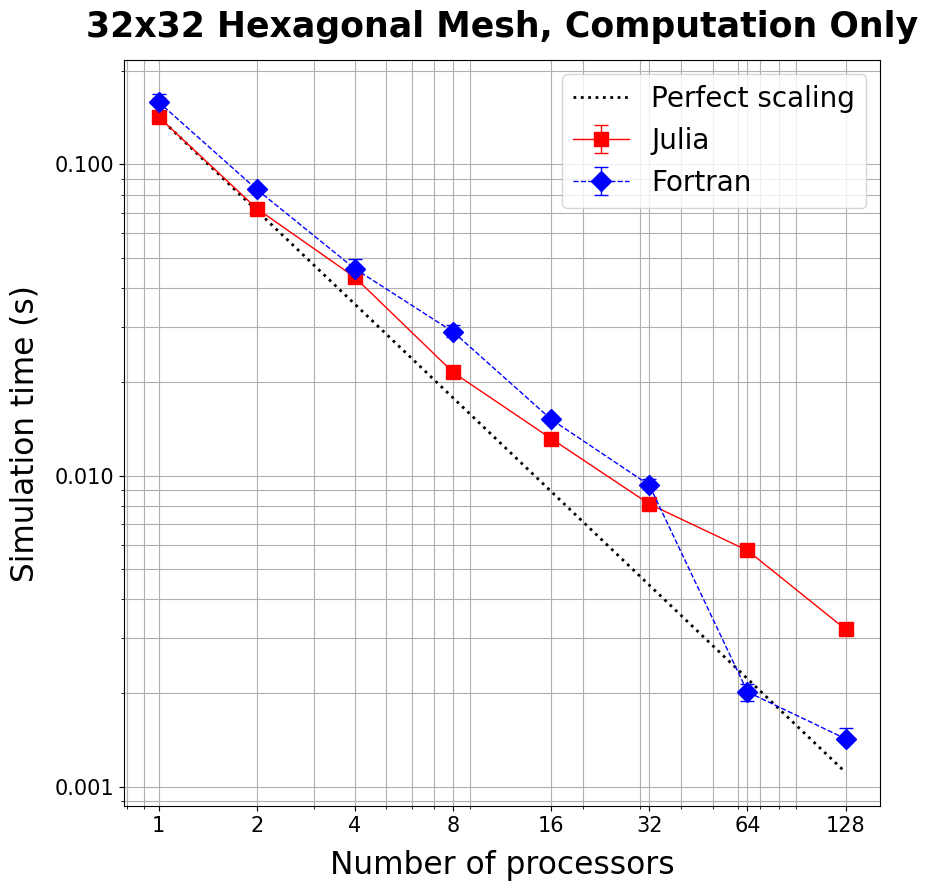

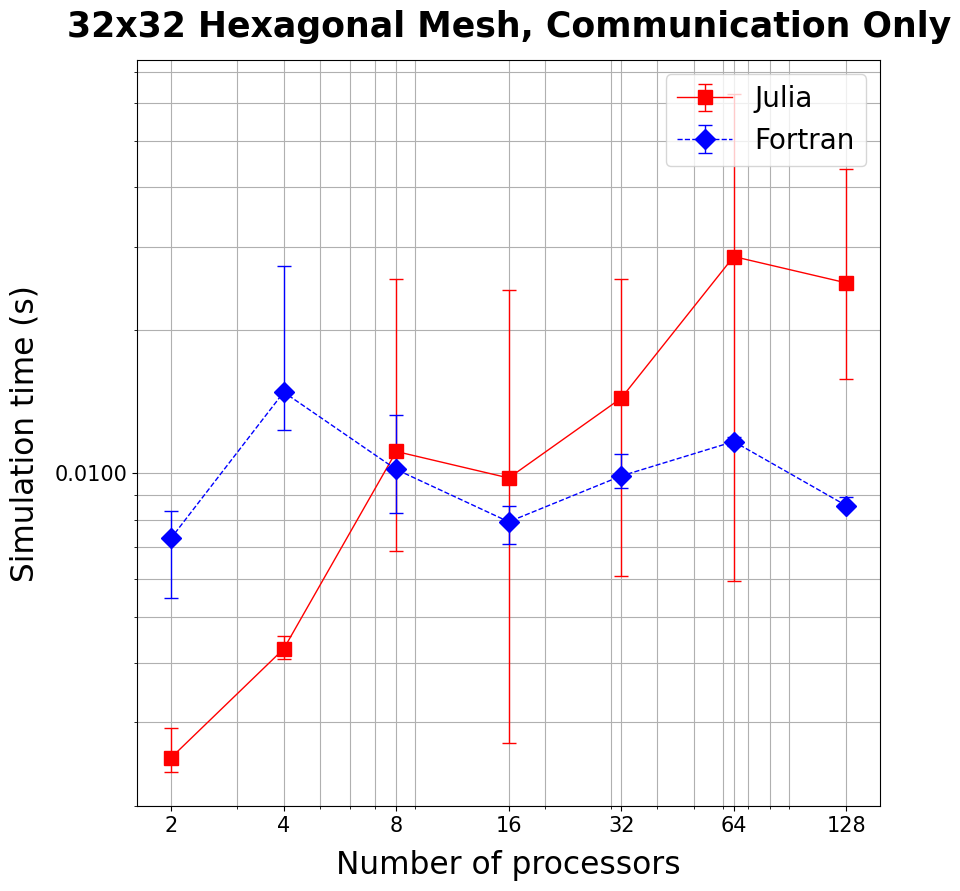

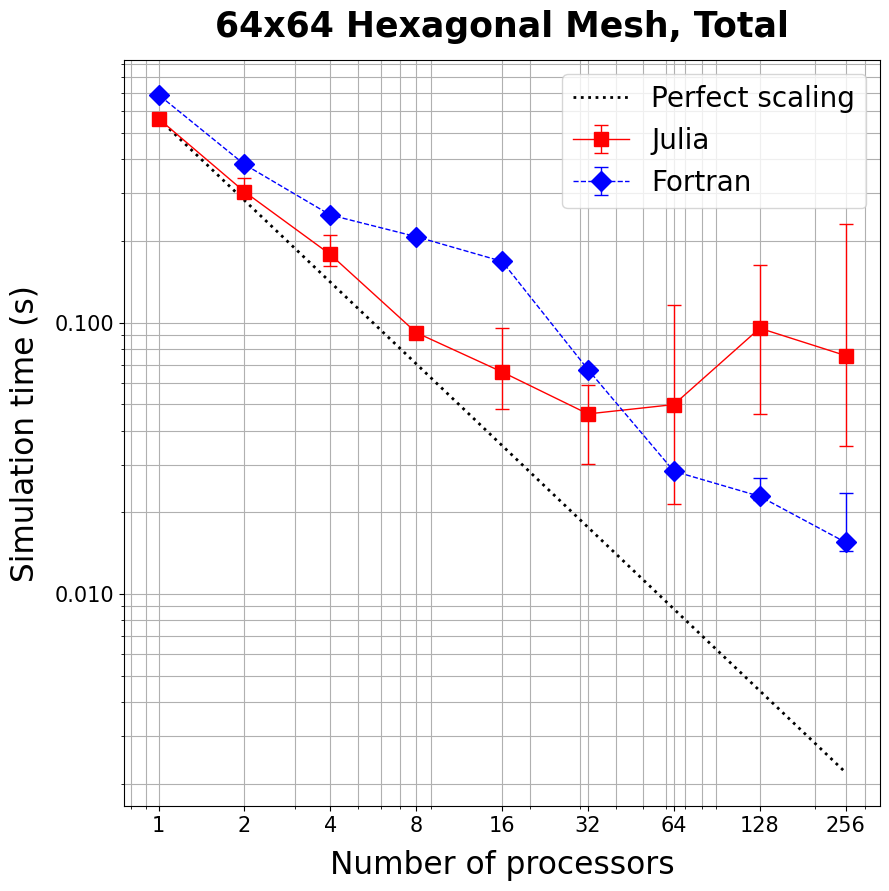

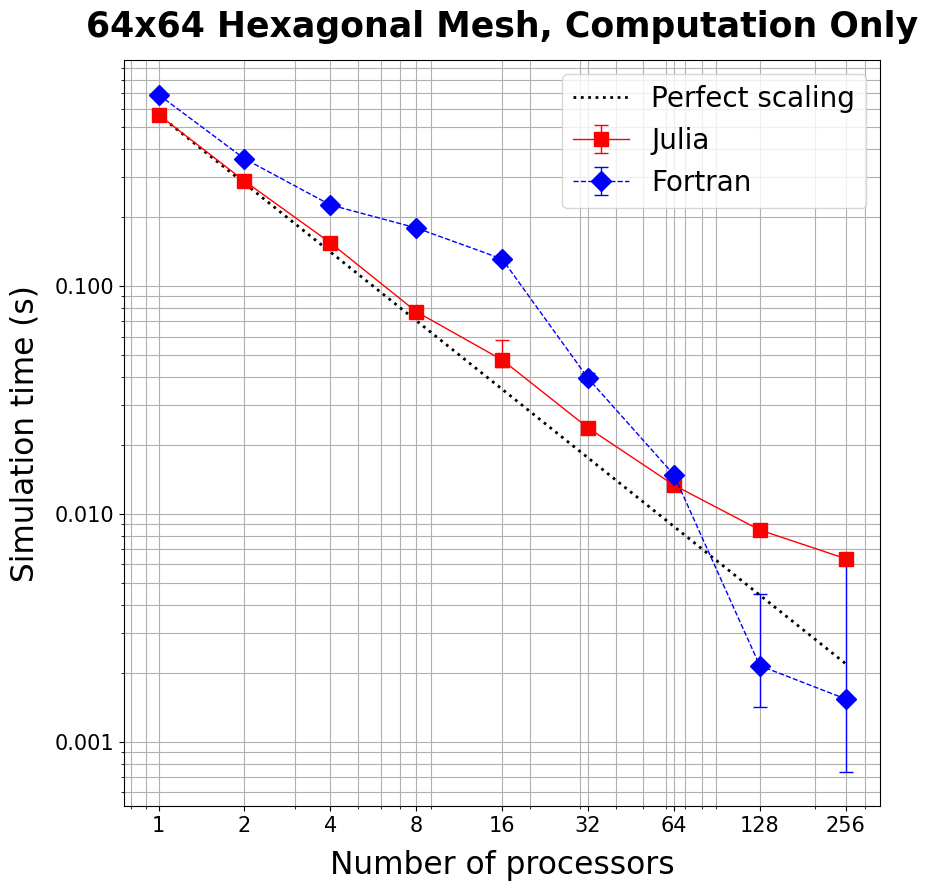

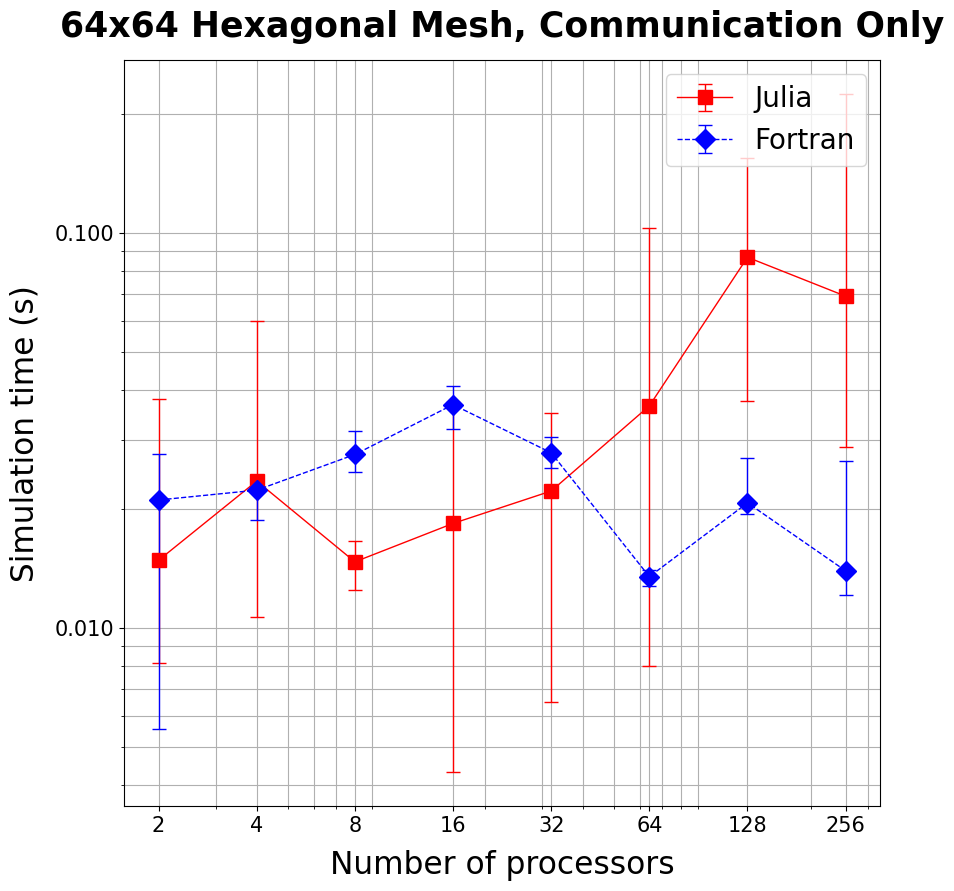

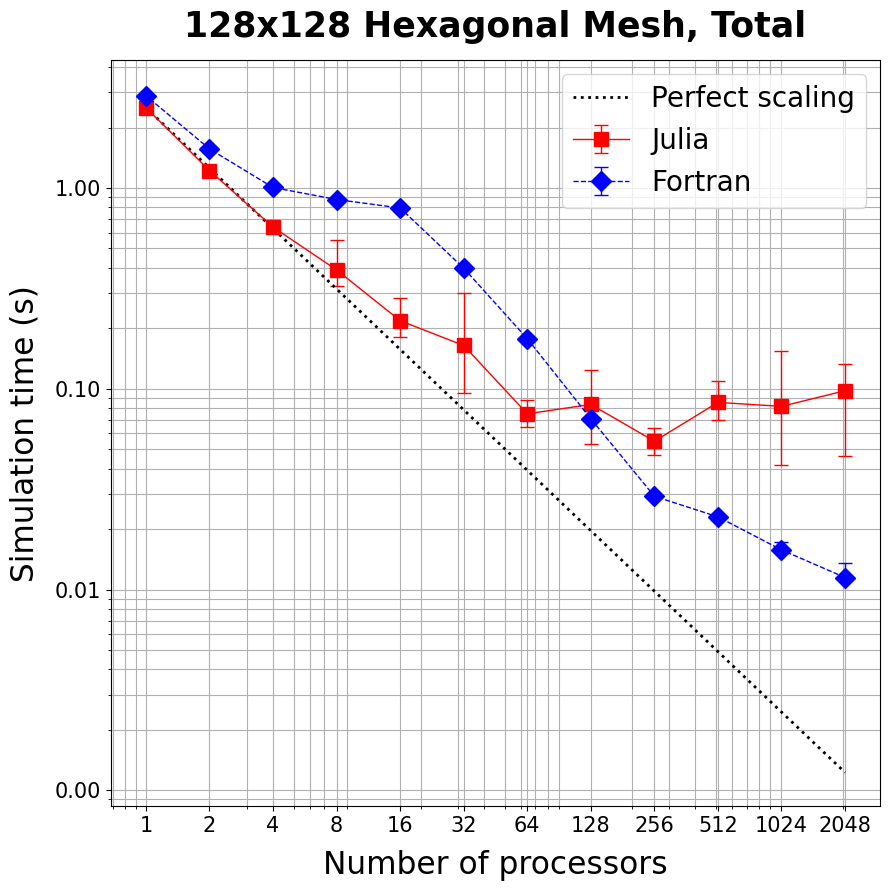

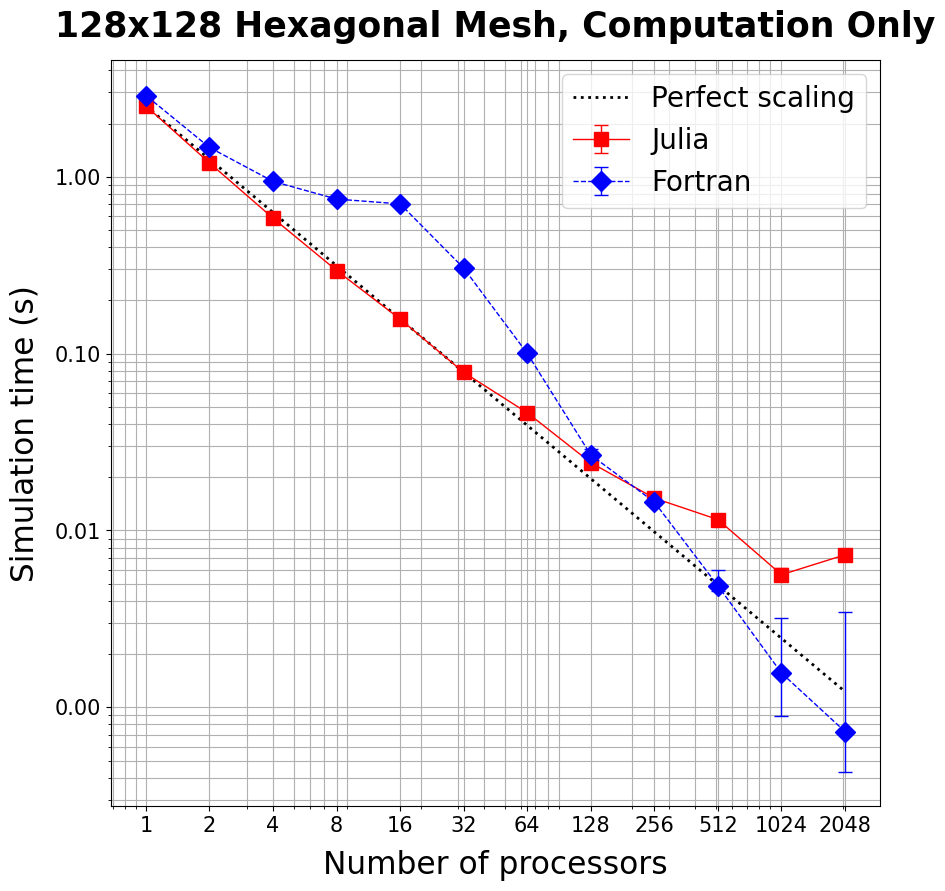

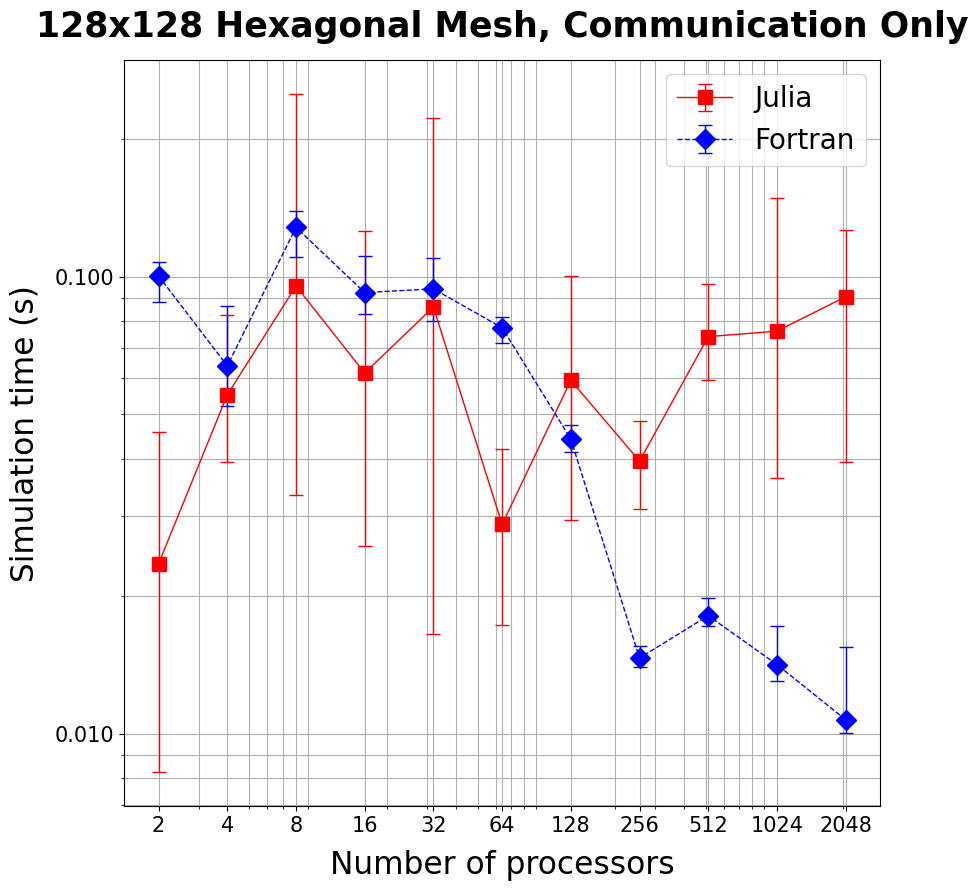

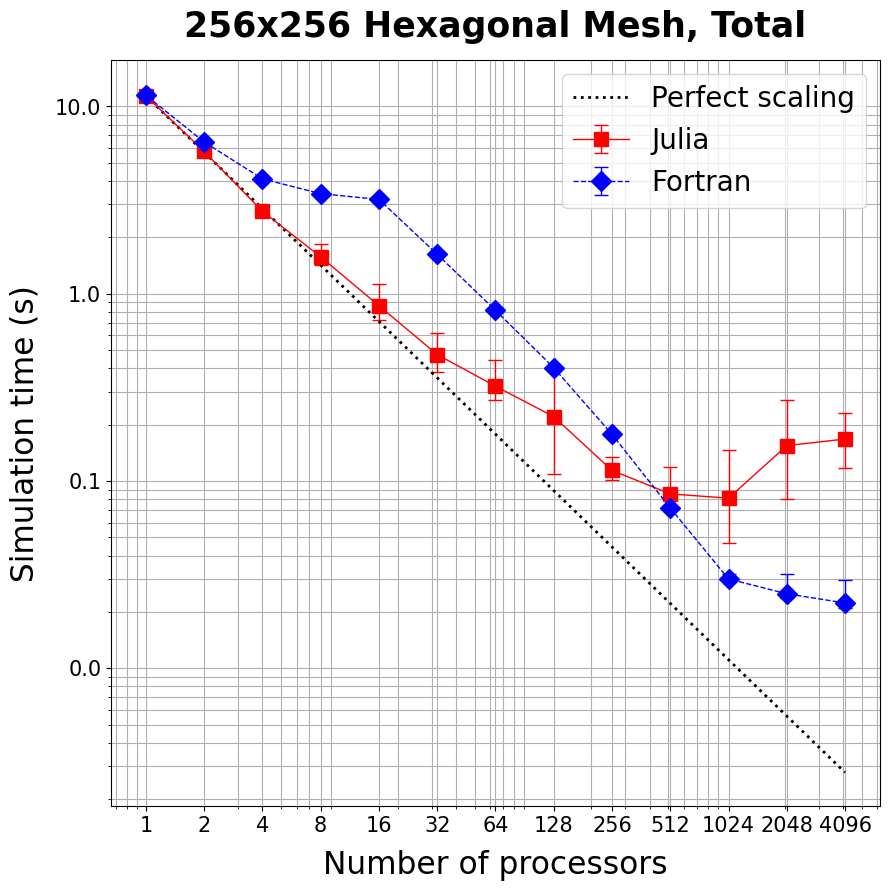

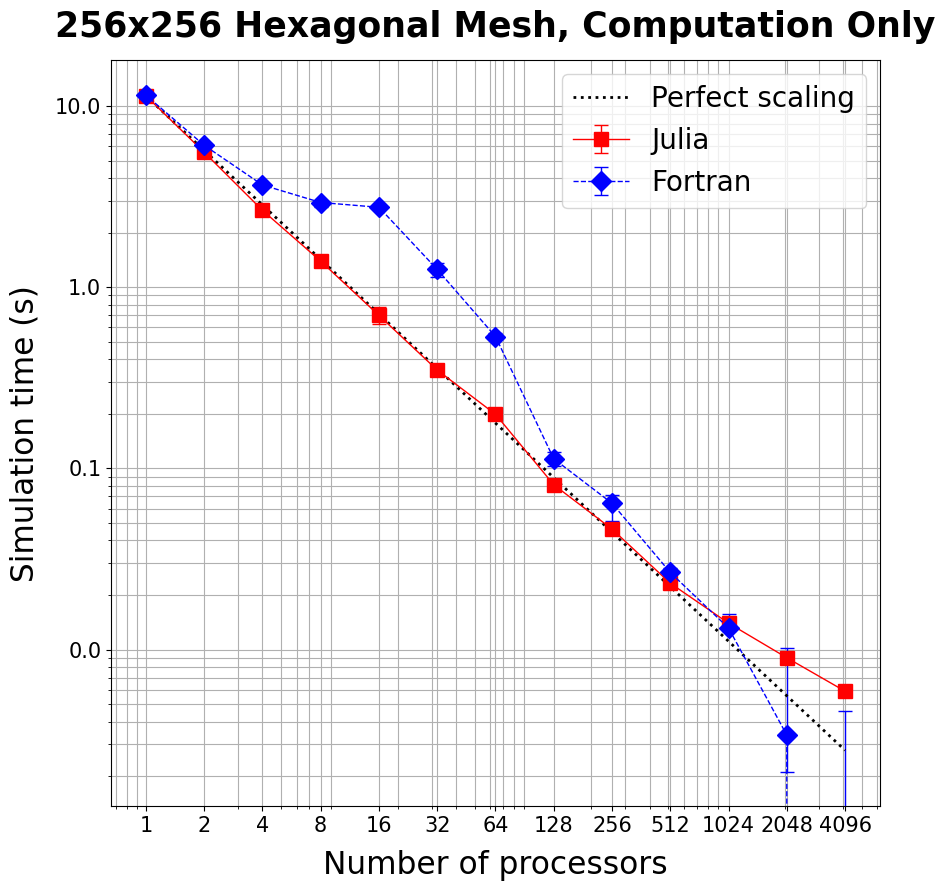

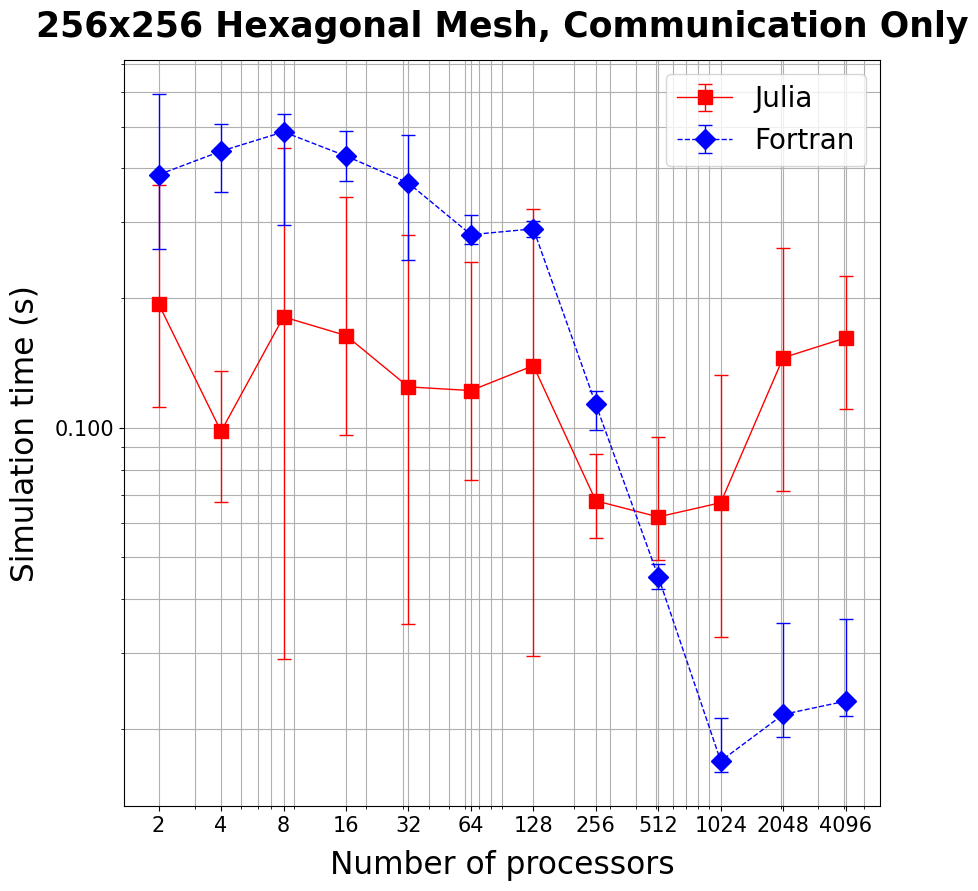

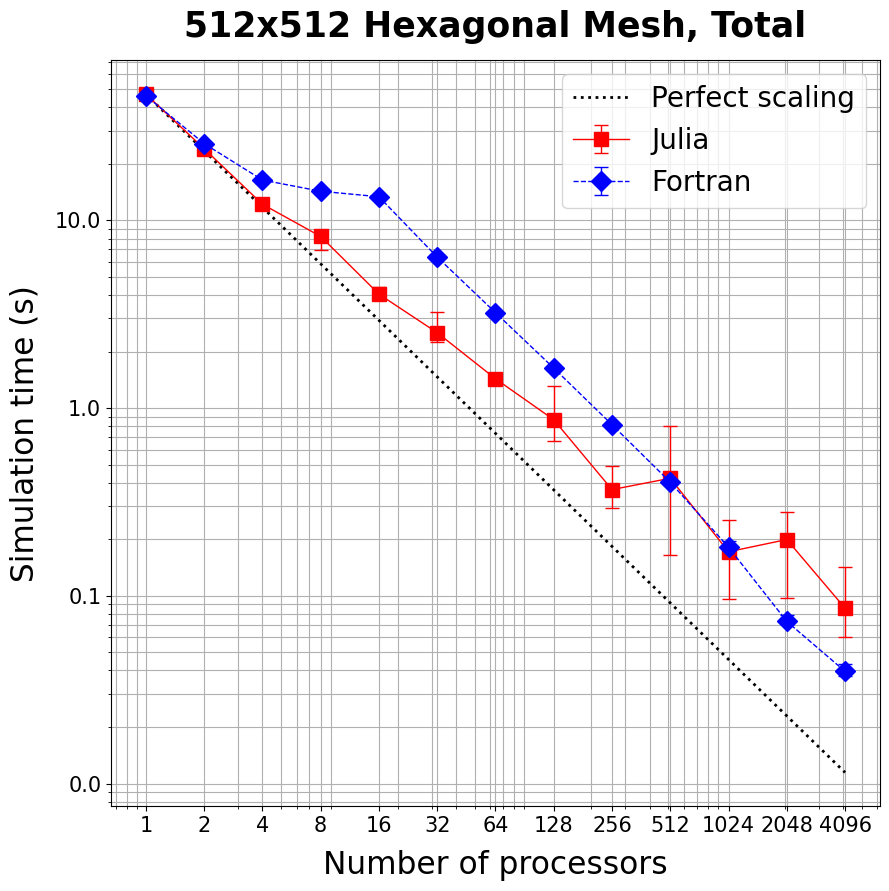

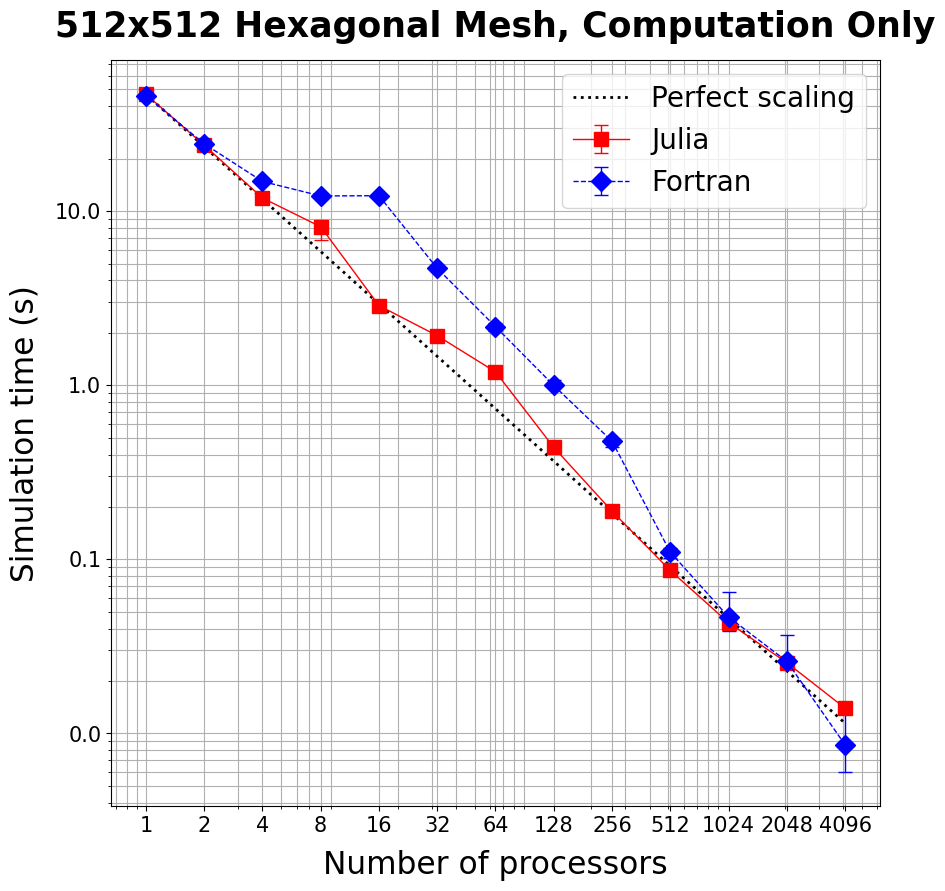

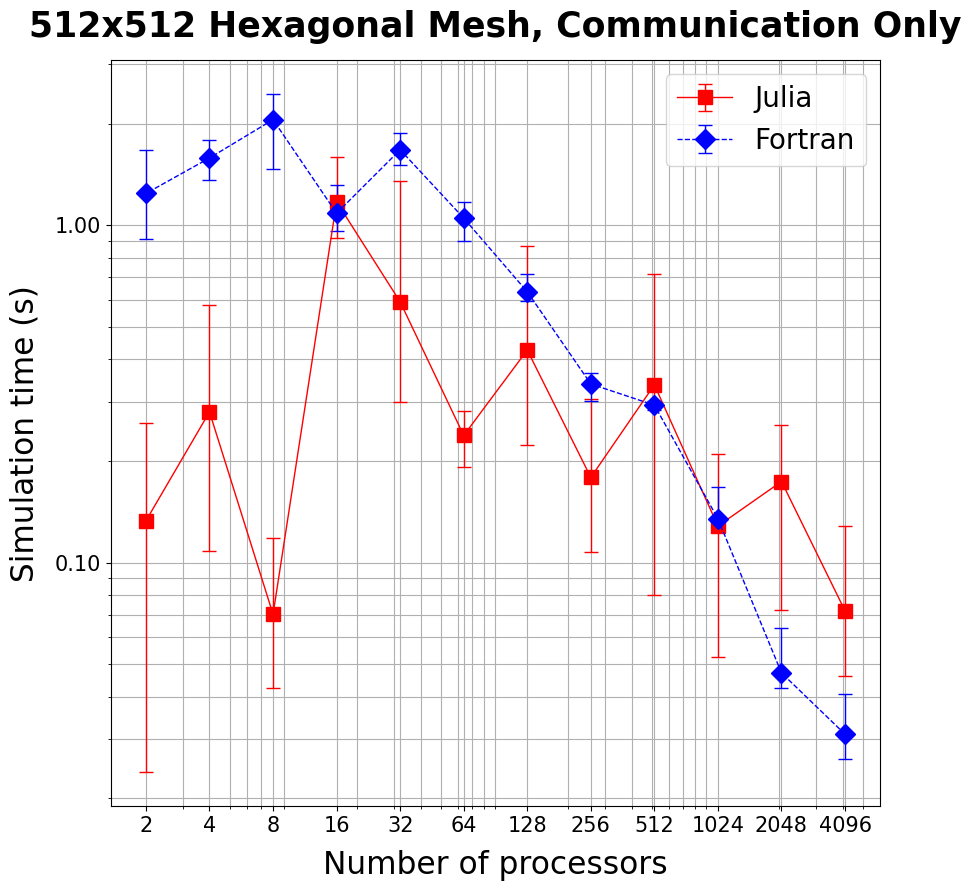

In [13]:
for nCellsX in [16, 32, 64, 128, 256, 512]
    jrun, jmpi, jprocs, jrunminmax, jmpiminmax, jfile = juliatimes(nCellsX, maxprocs[nCellsX])
    frun, fmpi, fprocs, frunminmax, fmpiminmax, ffile = fortrantimes(nCellsX, ftmaxprocs[nCellsX])
    
    if ftmaxprocs[nCellsX] > maxprocs[nCellsX]
        frun, fmpi, fprocs, frunminmax, fmpiminmax = frun[2:end], fmpi[2:end], fprocs[2:end], frunminmax[:,2:end], fmpiminmax[:,2:end]
    elseif ftmaxprocs[nCellsX] < maxprocs[nCellsX]
        jrun, jmpi, jprocs, jrunminmax, jmpiminmax = jrun[1:end-1], jmpi[1:end-1], jprocs[1:end-1], jrunminmax[:,1:end-1], jmpiminmax[:,1:end-1]
    end
    
    fig, ax = strongscalingplot(jrun, jprocs, frun, fprocs, nCellsX,
                        abs.(jrun' .- jrunminmax), abs.(frun' .- frunminmax))
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh, Total", fontsize=titlefontsize, fontweight="bold", y=1.02)
    if savefigs
        savename = replace(jfile[length(CODE_ROOT)+2:end], ("/" => "--"))
        fig.savefig("$(CODE_ROOT)/plots/strong_scaling/total_$(savename).pdf", bbox_inches="tight")
        println("saved at $(CODE_ROOT)/plots/strong_scaling/total_$(savename).pdf")
    end
    
    # gpufname = latestfile(CODE_ROOT *  "/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution$(nCellsX)x$(nCellsX)/steps10/nvlevels100/", x -> x[end-3:end] == ".txt")
    # gputimes = readdlm(gpufname)
    # simtimes = gputimes[1,:]
    # bustimes = gputimes[2,:]
    # meangpu = mean(simtimes[2:end])
    # meangpucom = mean(bustimes[2:end])
    # plt.axhline(y=meangpu, color="g")
    # plt.axhline(y=meangpucom, color="g", linestyle="--")

    
    fig1, ax1 = strongscalingplot(jrun - jmpi, jprocs, frun - fmpi, fprocs, nCellsX,
                            abs.((jrun' - jmpi') .- (jrunminmax .- jmpiminmax)), abs.((frun' - fmpi') .- (frunminmax .- fmpiminmax)))
    ax1.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh, Computation Only", fontsize=titlefontsize, fontweight="bold", y=1.02)
    fig2, ax2 = strongscalingplot(jmpi[2:end], jprocs[2:end], fmpi[1:end-1], fprocs[1:end-1], nCellsX, 
                            abs.(jmpi' .- jmpiminmax)[:,2:end], abs.(fmpi' .- fmpiminmax)[:,1:end-1], perfect=false)
    ax2.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh, Communication Only", fontsize=titlefontsize, fontweight="bold", y=1.02)
    
    # fig, ax = strongscalingplot2(jrun .- jmpi, jrunminmax, jmpi, jmpiminmax, jprocs, frun .- fmpi, frunminmax, fmpi, fmpiminmax, fprocs, nCellsX)
    
    if savefigs
        savename = replace(jfile[length(CODE_ROOT)+2:end], ("/" => "--"))
        fig1.savefig("$(CODE_ROOT)/plots/strong_scaling/calc_only_$(savename).pdf", bbox_inches="tight")
        fig2.savefig("$(CODE_ROOT)/plots/strong_scaling/comm_only_$(savename).pdf", bbox_inches="tight")
        println("saved at $(CODE_ROOT)/plots/strong_scaling/calc_only_$(savename).pdf")
    end
    
    println(jfile[end-60:end])
    println(ffile[end-60:end])
end

In [109]:
function timesplitplot(nprocs, comptime, mpitime, nCellsX, info="")
    fontscale = 2
    
    fig, ax = plt.subplots(1,1, figsize=(length(comptime)*3,8))
#     df = DataFrame(processors=nprocs, computation=comptime, communication=mpitime)
#     df.plot(kind="bar", 
#             stacked=true, 
#             colormap="tab10", 
#             figsize=(10, 6))
    totals = comptime + mpitime
    
    ax.bar(string.(Int.(nprocs)), comptime ./ totals, color="blue", label="Computation")
    ax.bar(string.(Int.(nprocs)), mpitime ./ totals, bottom=comptime ./ totals, color="red", label="Communication")
    
    ax.legend(loc="center left", fontsize=20*fontscale, bbox_to_anchor=(1,0.5))
    
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlabel("Number of processors", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.set_ylabel("Proportion of time", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.tick_params(axis="x", labelsize=20*fontscale)
    ax.tick_params(axis="y", labelsize=20*fontscale)
    
    # " using $(nCellsX)x$(nCellsX) Hexagonal Mesh"
    ax.set_title("$info: Proportion of Simulation Time \nSpent on Computation and Communication", fontweight="bold", fontsize=30*fontscale, y=1.08)
    
#     plt.tick_params(top="off", bottom="off", left="off", right="off", labelleft="off", labelbottom="on")
    
    # plt.tight_layout()
    
    return fig, ax
end

timesplitplot (generic function with 2 methods)

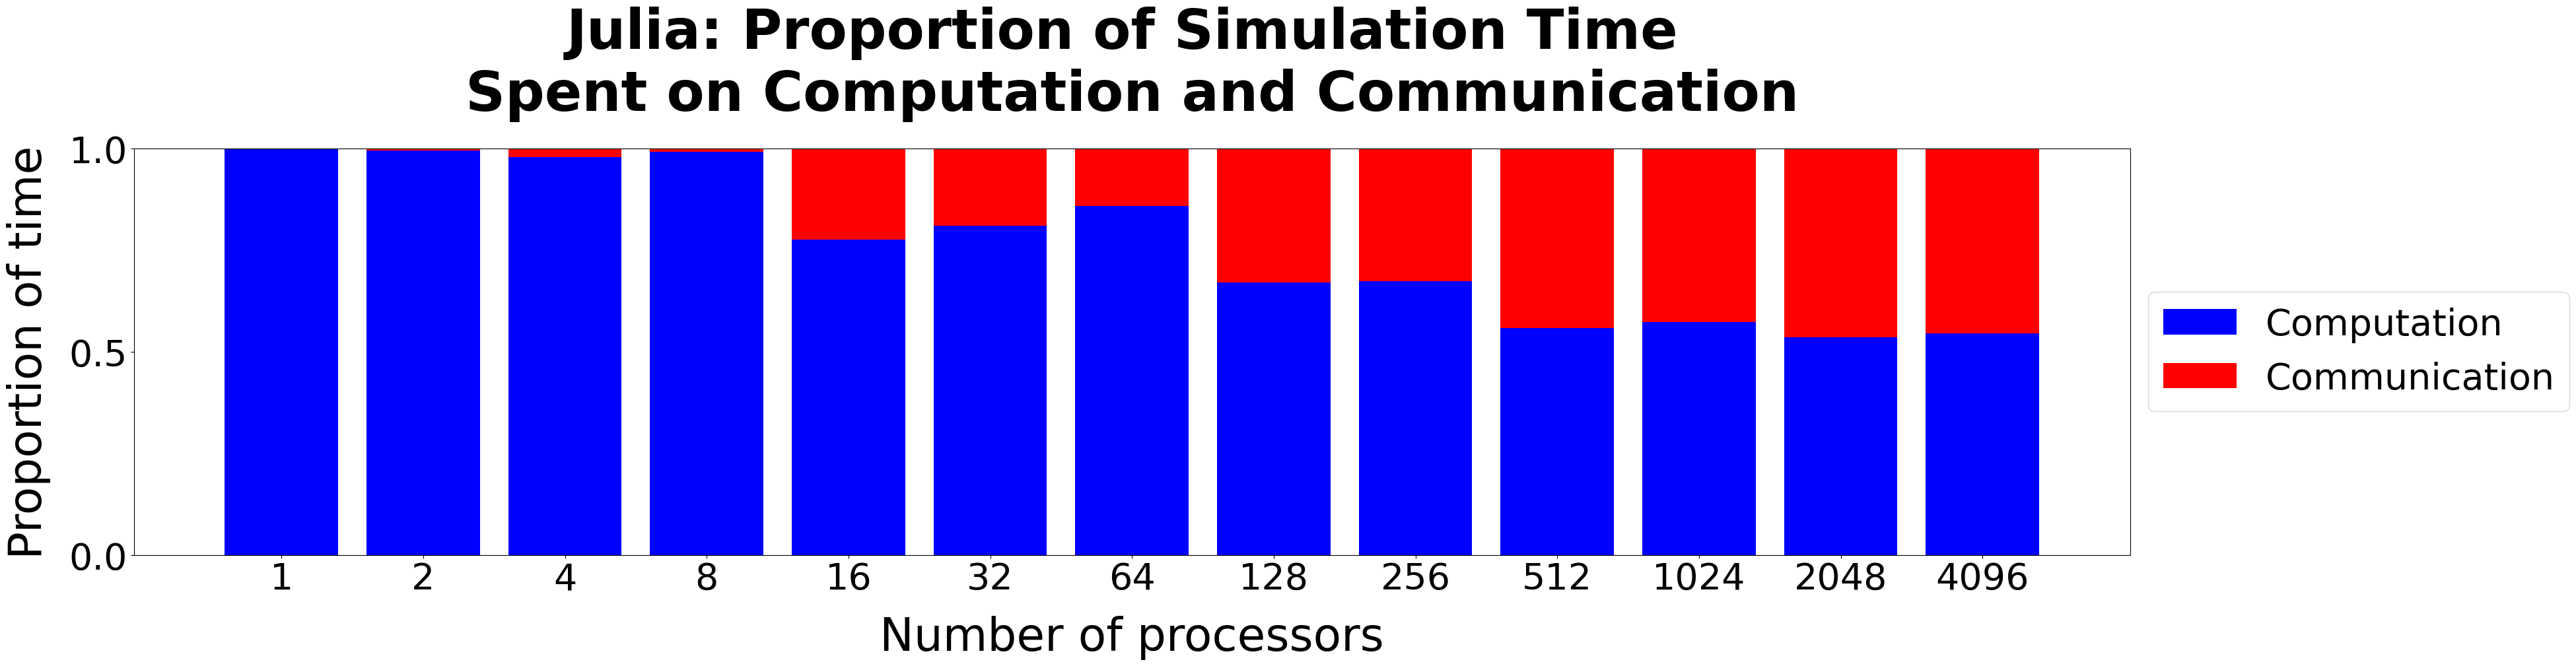

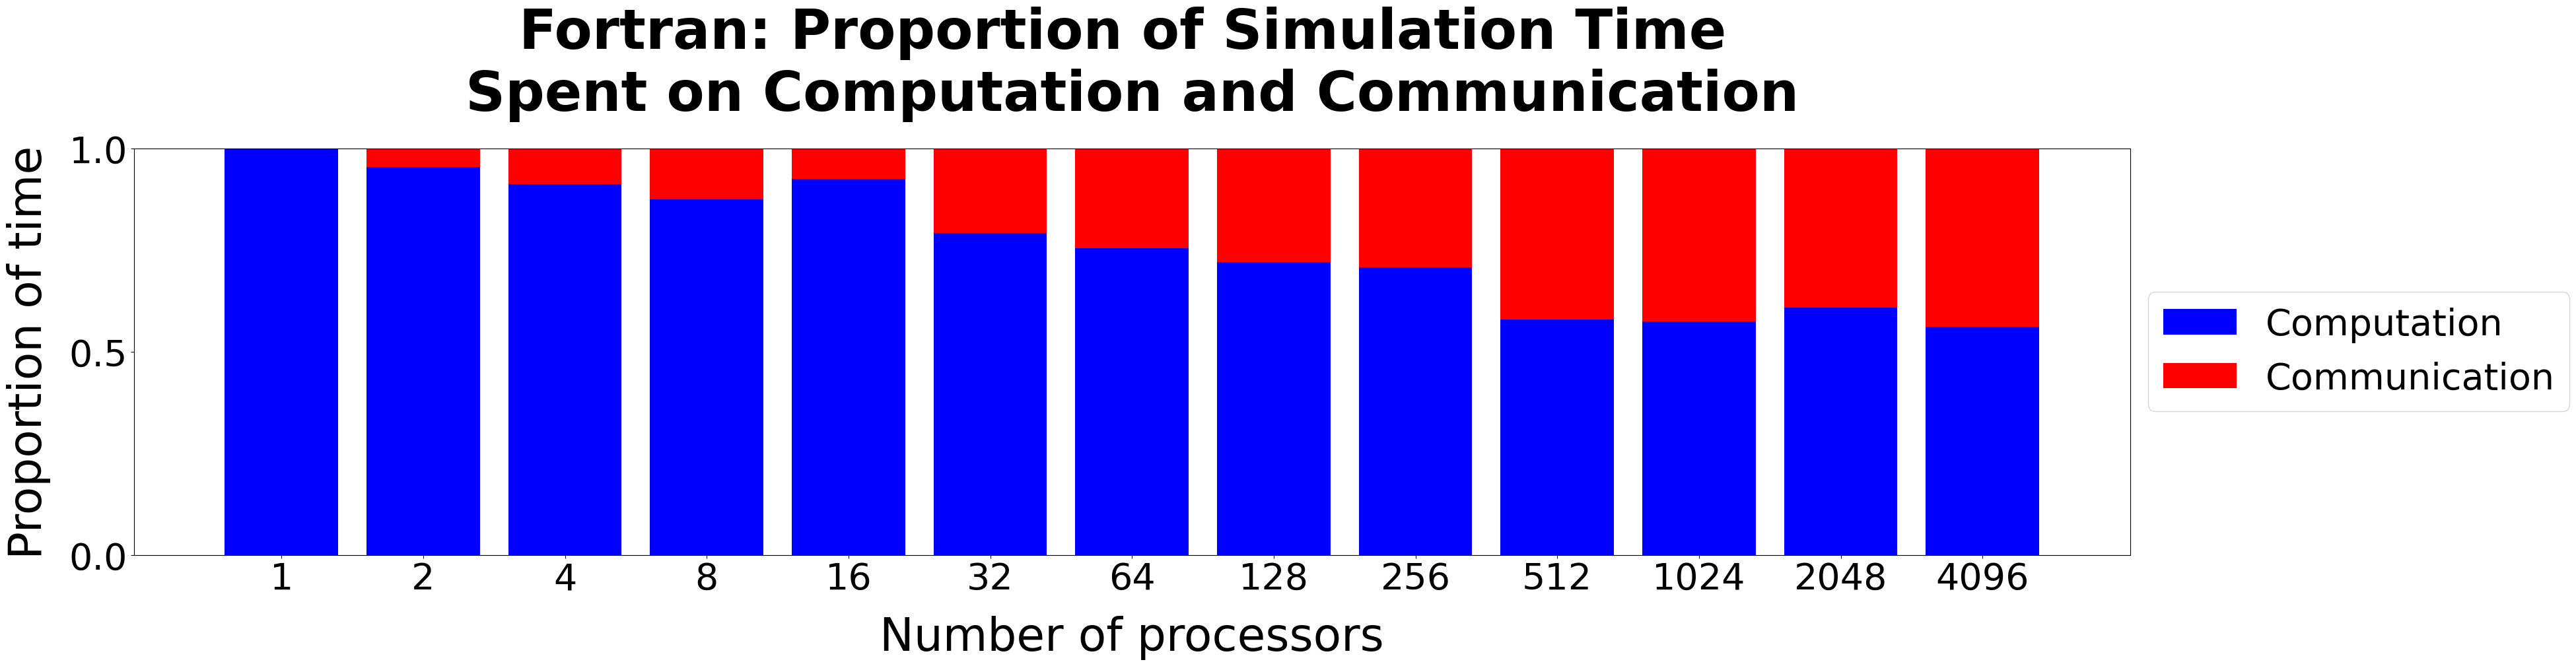

In [111]:
nCellsX = 512
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimminmax, juliampiminmax = juliafortrantimesplits(nCellsX)

fig1, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig2, ax = timesplitplot(fortranprocs[end:-1:1], fortransim[end:-1:1], fortranmpi[end:-1:1], nCellsX, "Fortran")

if savefigs
    savenamejl = replace(juliafname[length(CODE_ROOT)+2:end], ("/" => "--"))
    savenameft = replace(fortranfname[length(CODE_ROOT)+2:end], ("/" => "--"))
    fig1.savefig("$(CODE_ROOT)/plots/time_proportion/julia_$(savenamejl).pdf", bbox_inches="tight")
    # fig1.savefig("$(juliafname)_proportion_sim_mpi.pdf", bbox_inches="tight")
    fig2.savefig("$(CODE_ROOT)/plots/time_proportion/fortran_$(savenameft).pdf", bbox_inches="tight")
end

In [80]:
collect([findall(x -> x in a, [ 8, 7, 6, 5, 4, 3, 2, 1]) for a in [3, 4, 5]])

3-element Vector{Vector{Int64}}:
 [6]
 [5]
 [4]

In [203]:
function weakscalingplot(;which="total", resolutions = [16, 32, 64, 128, 256, 512], constlines = [64], mode="weak_scaling", gpu=false)
    function constline(ncells, procs)
        if mode == "weak_scaling"
            return ncells ./ procs
        elseif mode == "constant_nprocs"
            return procs
        else 
            error("unknown mode")
        end
    end
    
    if mode == "constant nprocs" && constlines == [64]
        global FORTRAN_DATA_ROOT = CODE_ROOT * "/data/fortran-timing/timing64_plane"
    else
        global FORTRAN_DATA_ROOT = CODE_ROOT * "/data/fortran-timing"
    end
    
    jltimes   = zeros((  length(resolutions),length(constlines)))
    jlminmaxs = zeros((2,length(resolutions),length(constlines)))
    fttimes   = zeros((  length(resolutions),length(constlines)))
    ftminmaxs = zeros((2,length(resolutions),length(constlines)))
    gputimes  = zeros((  length(resolutions),length(constlines)))
    gpuminmaxs= zeros((2,length(resolutions),length(constlines)))
    fnames = Vector{String}(undef, length(resolutions))
    
    for (i, nCellsX) in enumerate(resolutions)
    
        jrun, jmpi, jprocs, jrunminmax, jmpiminmax, fnames[i] = juliatimes(nCellsX, maxprocs[nCellsX])
        ind = []
        for con in constlines
            ind = vcat(ind, findall(x->x==con, constline(nCellsX^2, jprocs)))
        end
        
        if which == "total"
            jltimes[i,:] = jrun[ind]
            jlminmaxs[:,i,:]  = jrunminmax[:,ind]
        elseif which == "mpi"
            jltimes[i,:] = jmpi[ind]
            jlminmaxs[:,i,:] = jrunminmax[:,ind]
        elseif which == "comp"
            jltimes[i,:] = jrun[ind] - jmpi[ind]
            jlminmaxs[:,i,:]  = jrunminmax[:,ind] - jmpiminmax[:,ind]
        end
        
        if mode == "constant nprocs" && constlines == [64]
            if nCellsX == 512
                frun, fmpi, fprocs, frunminmax, _, _ = fortrantimes(nCellsX, 4096)
            else
                frun, fmpi, fprocs, frunminmax, _, _ = fortrantimes(nCellsX, 64)
            end
        else
            frun, fmpi, fprocs, frunminmax, fmpiminmax, _ = fortrantimes(nCellsX, ftmaxprocs[nCellsX])
        end
        ind = []
        for con in constlines
            ind = vcat(ind, findall(x->x==con, constline(nCellsX^2, fprocs)))
        end
        
        if which == "total"
            fttimes[i,:] = frun[ind]
            ftminmaxs[:,i,:]  = frunminmax[:,ind]
        elseif which == "mpi"
            fttimes[i,:] = fmpi[ind]
            ftminmaxs[:,i,:]  = fmpiminmax[:,ind]
        elseif which == "comp"
            fttimes[i,:] = frun[ind] - fmpi[ind]
            ftminmaxs[:,i,:]  = frunminmax[:,ind] - fmpiminmax[:,ind]
        end
        
        if gpu
            gpufname = latestfile(CODE_ROOT *  "/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution$(nCellsX)x$(nCellsX)/steps10/nvlevels100/", x -> x[end-3:end] == ".txt")
            gputtimes = readdlm(gpufname)
            simtimes = gputtimes[1,:]
            bustimes = gputtimes[2,:]
            if which == "total"
                times = simtimes[2:end] + bustimes[2:end]
            elseif which == "mpi"
                times = bustimes[2:end]
            elseif which == "comp"
                times = simtimes[2:end]
            end
            gpuminmaxs[:,i,:] = vcat(minimum(times), maximum(times))
            gputimes[i,:] .= mean(times)
        end
        
    end
    
    # plot
    
    for (i, con) in enumerate(constlines)
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylabel("Simulation time (s)", fontsize=labelfontsize, labelpad=10)
        
        if which == "total"
            whichname = "Total"
        elseif which == "mpi"
            whichname = "Communication Only"
        elseif which == "comp"
            whichname = "Computation Only"
        end
        if mode == "weak_scaling"
            ax.set_title("Weak Scaling ($(whichname)), $(con) Cells/Process", fontsize=titlefontsize, fontweight="bold", y=1.02)
            ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
            xaxis = Int.(resolutions .^ 2 / con) # = num proccessors
            xlabels = xaxis
        elseif mode == "constant_nprocs"
            ax.set_title("Resolution Scaling ($(whichname)), $(con) Processes", fontsize=titlefontsize, fontweight="bold", y=1.02)
            ax.set_xlabel("Mesh size", fontsize=labelfontsize, labelpad=10)
            xaxis = resolutions .^ 2 # mesh size
            xlabels = string.(resolutions) .* "x" .* string.(resolutions)
        end
        
        julialines = ax.errorbar(xaxis, jltimes[:,i], yerr=abs.(jltimes[:,i]' .-jlminmaxs[:,:,i]), label="Julia MPI", 
                        capsize=5, linewidth=linewidth, linestyle="-", marker="s", markersize=markersize, color=red)
        fortranlines = ax.errorbar(xaxis, fttimes[:,i], yerr=abs.(fttimes[:,i]' .-ftminmaxs[:,:,i]), label="Fortran MPI",
                        capsize=5, linewidth=linewidth, linestyle="--", marker="D", markersize=markersize, color=blue)
        if gpu
            gpuline = ax.errorbar(xaxis, gputimes[:,i], yerr=abs.(gputimes[:,i]' .- gpuminmaxs[:,:,i]), label="Julia GPU",
                        capsize=5, linewidth=linewidth, linestyle=":", marker="o", markersize=markersize, color="green")
        end
        
        low = minimum(vcat(jltimes[:,i] + fttimes[:,i]))
        high = maximum(vcat(jltimes[:,i] + fttimes[:,i]))
        ax.set_ylim(low/5, high*5)
        ax.set_xticks(xaxis)
        ax.tick_params(axis="x", labelsize=tickfontsize)
        ax.tick_params(axis="y", labelsize=tickfontsize)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.set_xticklabels(xlabels)
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.legend(loc="upper center", fontsize=labelfontsize-2.5)
        ax.grid(which="both")
        plt.tight_layout()
        
        if mode == "weak_scaling" && which == "mpi" && xaxis[1] == 1
            # clip out single-processor communication time as this is meaningless
            # julialines[1].set_markevery((2,1))
            julialines[1].set_data(xaxis[2:end], jltimes[2:end,i])
            fortranlines[1].set_data(xaxis[2:end], fttimes[2:end,i])
            for errorbar in [ julialines[3][1], fortranlines[3][1] ]
                errorbar.set_alpha(vcat(0, [1 for i in 2:length(xaxis)]))
            end
            for cap in (julialines[2]..., fortranlines[2]...)
                # julialines[2][1].remove()
                capdata = cap.get_data()
                cap.set_data((capdata[1][2:end], capdata[2][2:end]))
            end
            # fortranlines[1].set_markevery((2,1))
        end
        
        if savefigs
            savename = replace(fnames[end][length(CODE_ROOT)+2:end], ("/" => "--"))
            hasgpu = gpu ? "and-gpu_" : ""
            savepath = "$(CODE_ROOT)/plots/$(mode)/$(which)_$(con)_$(hasgpu)$(resolutions[1])x-$(resolutions[end])x_$(savename).pdf"
            fig.savefig(savepath, bbox_inches="tight")
            println("saved at $(savepath)")
        end
    end
end

weakscalingplot (generic function with 1 method)

saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/weak_scaling/total_64_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/weak_scaling/total_128_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/weak_scaling/total_256_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/weak_scaling/mpi_64_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/weak_scaling/mpi_128_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstr

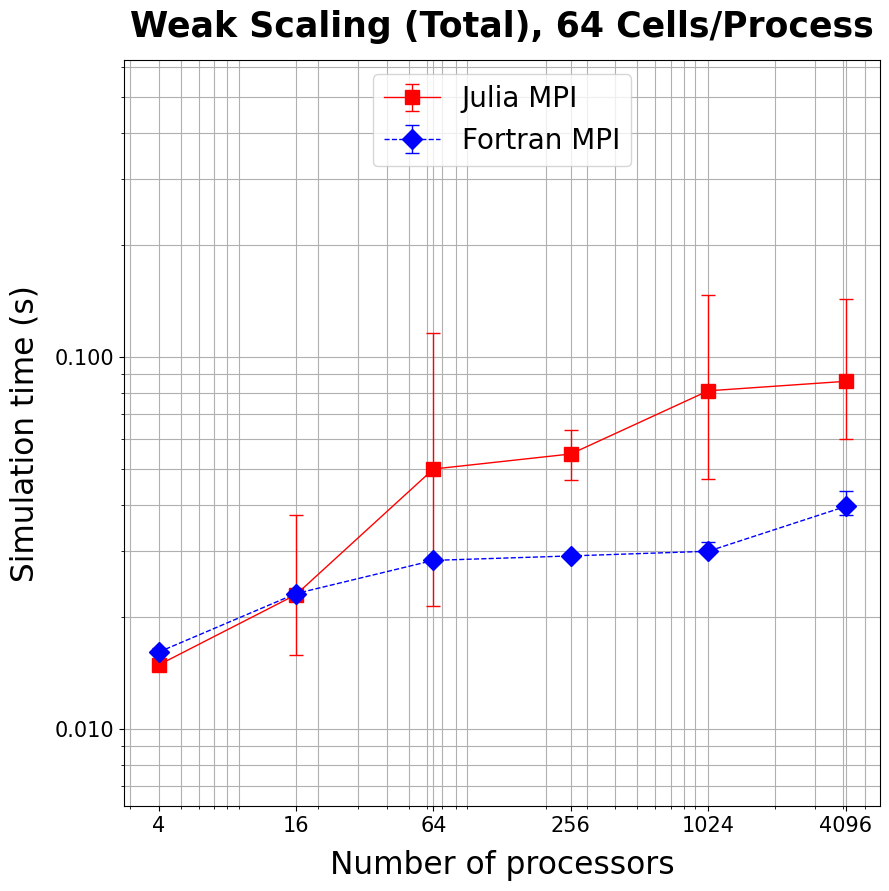

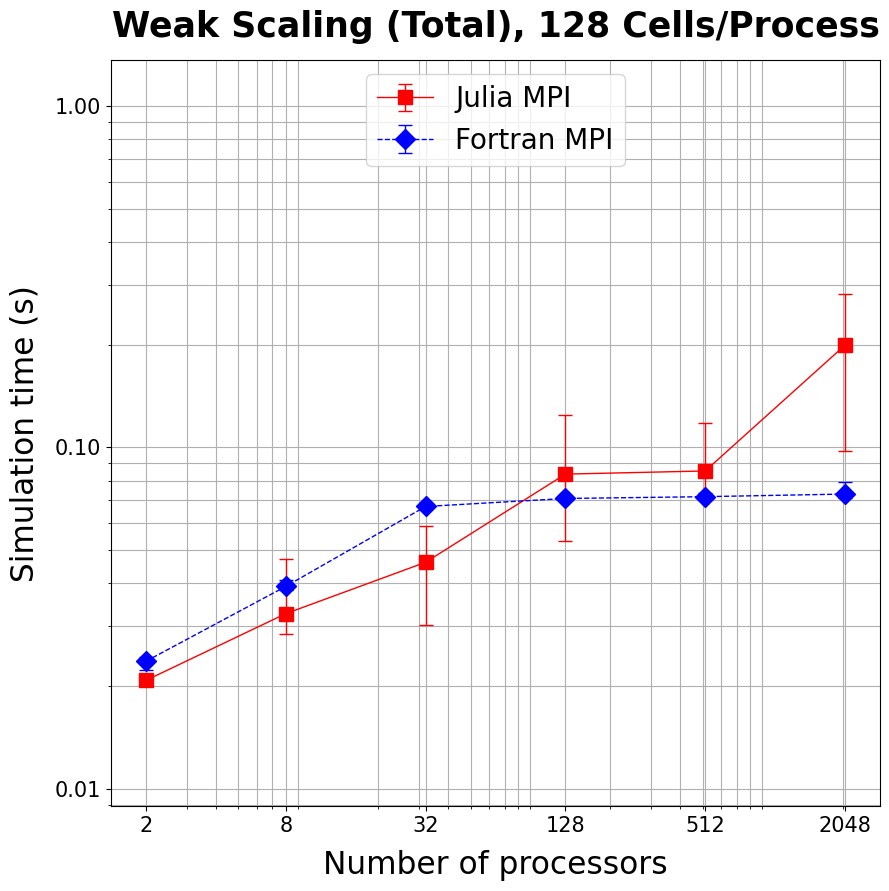

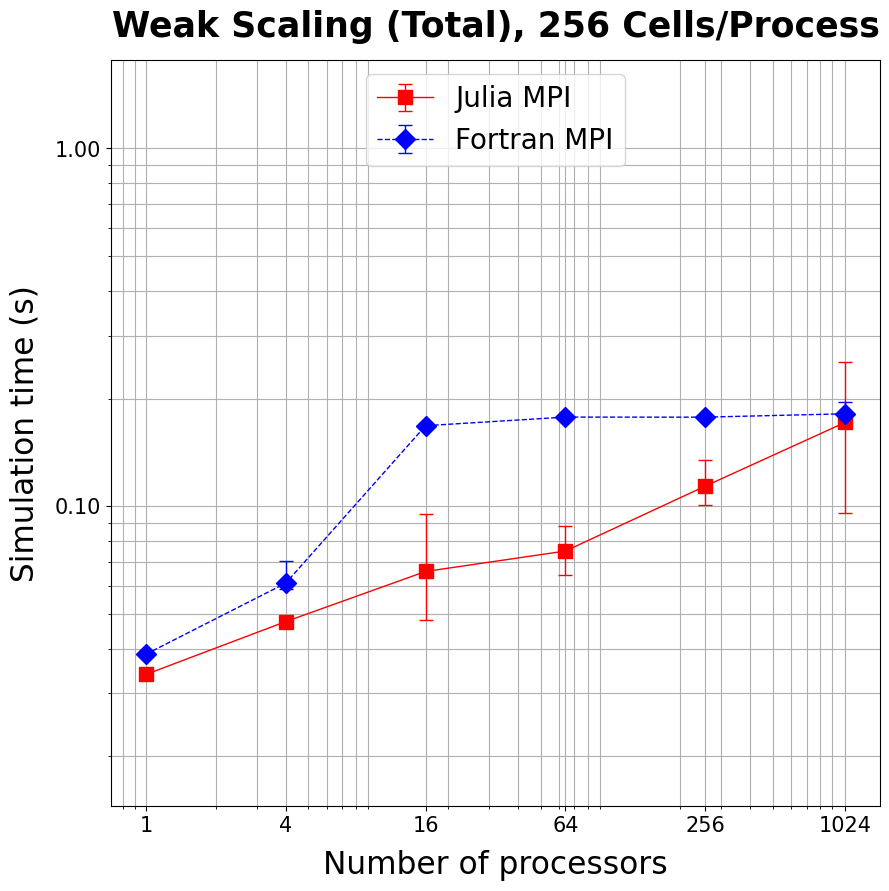

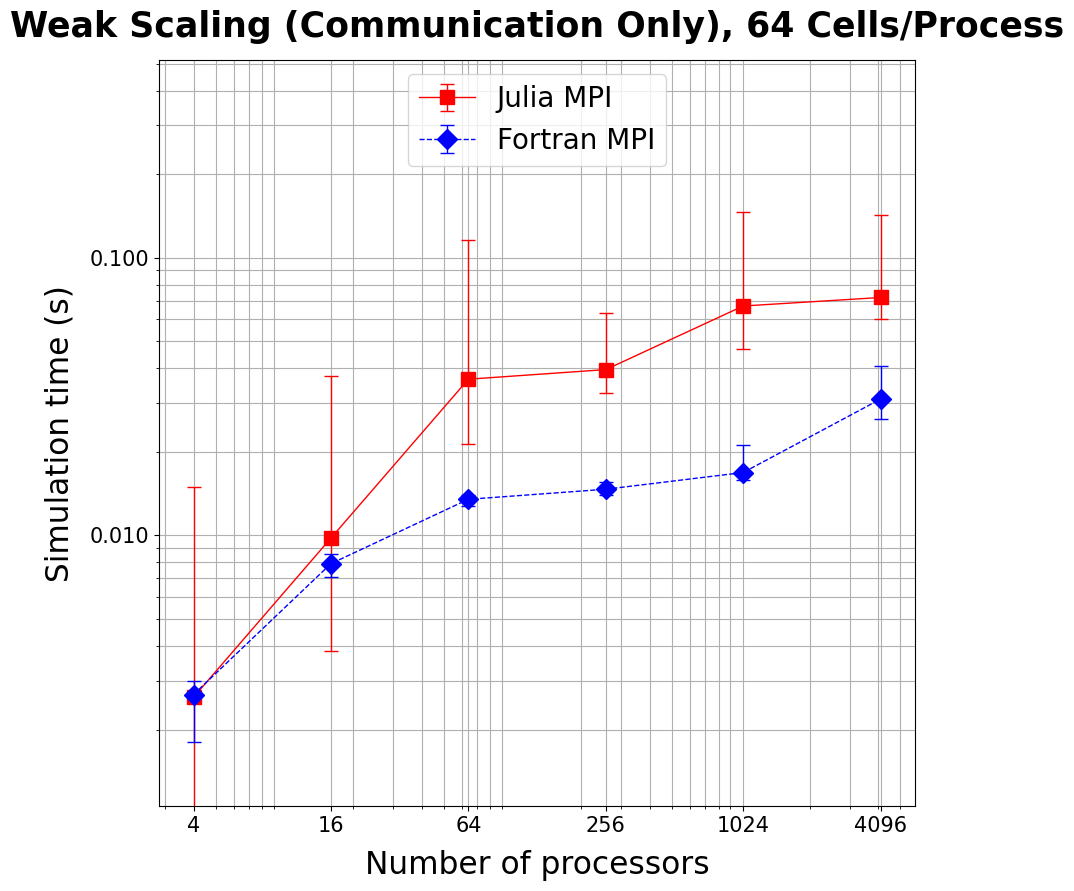

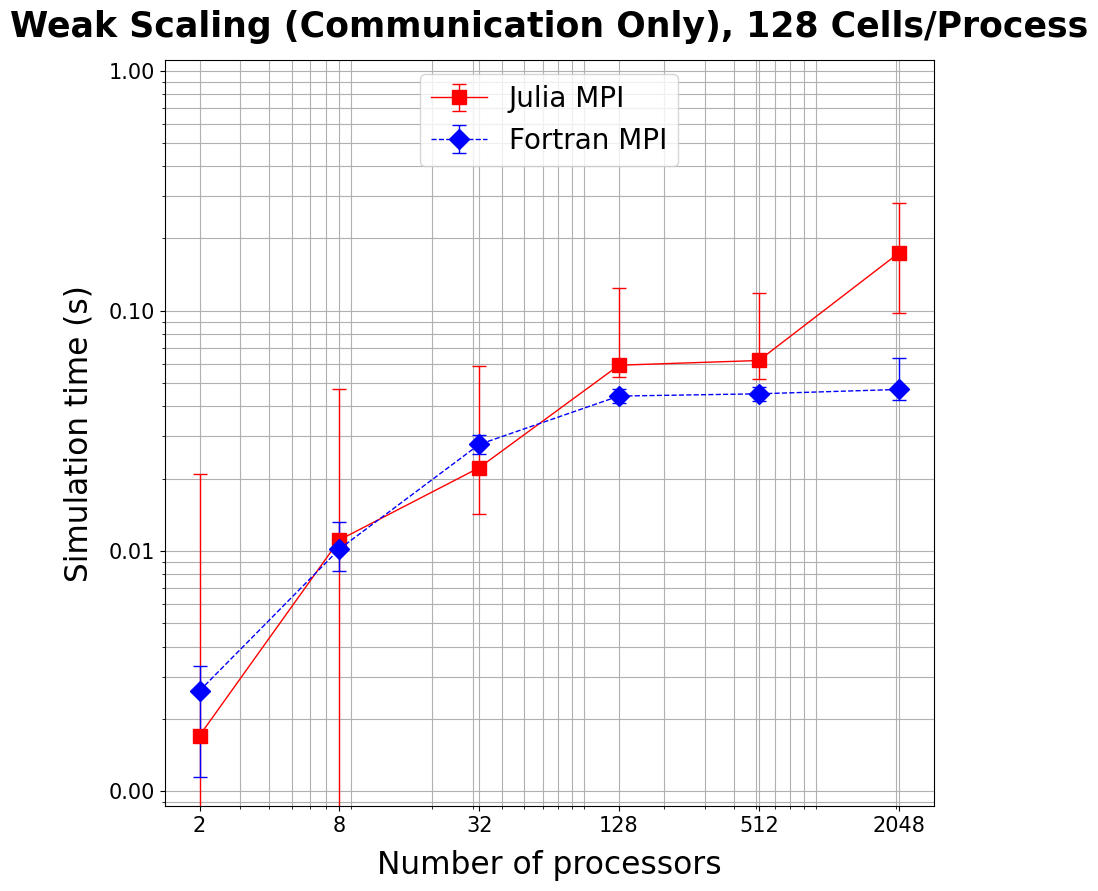

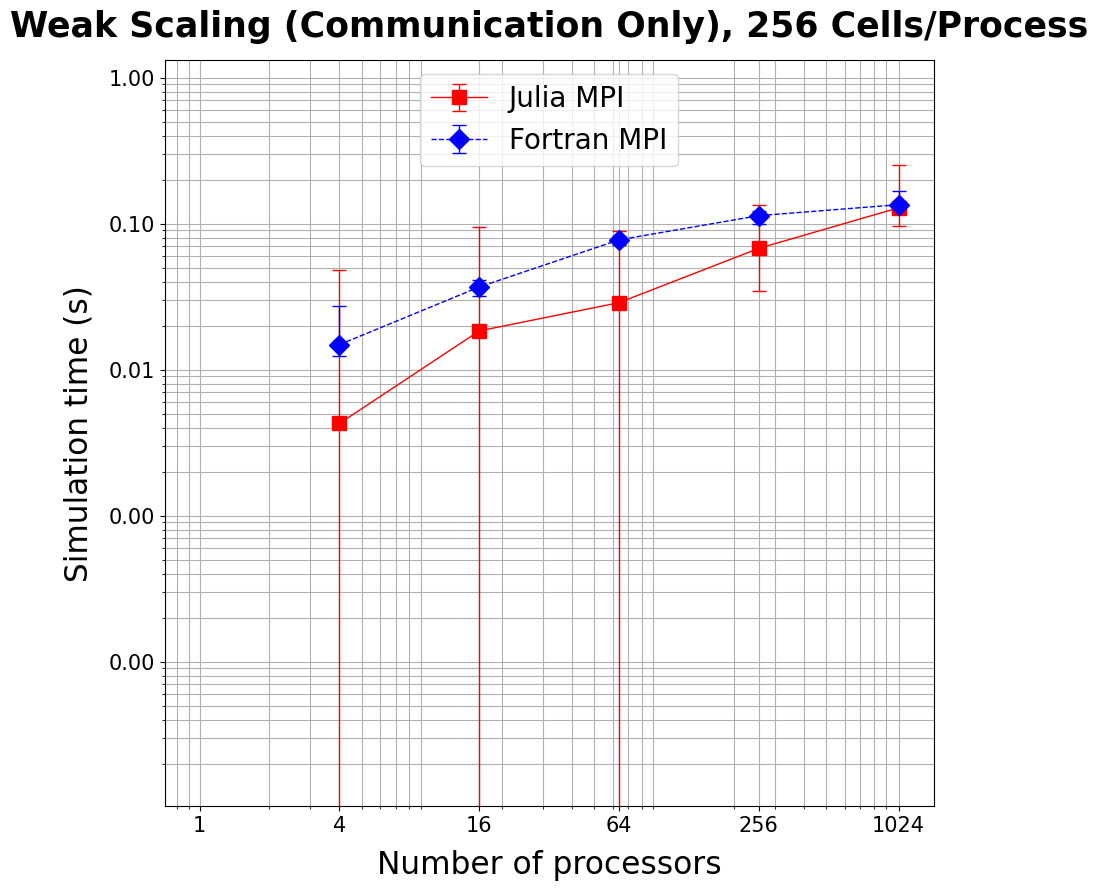

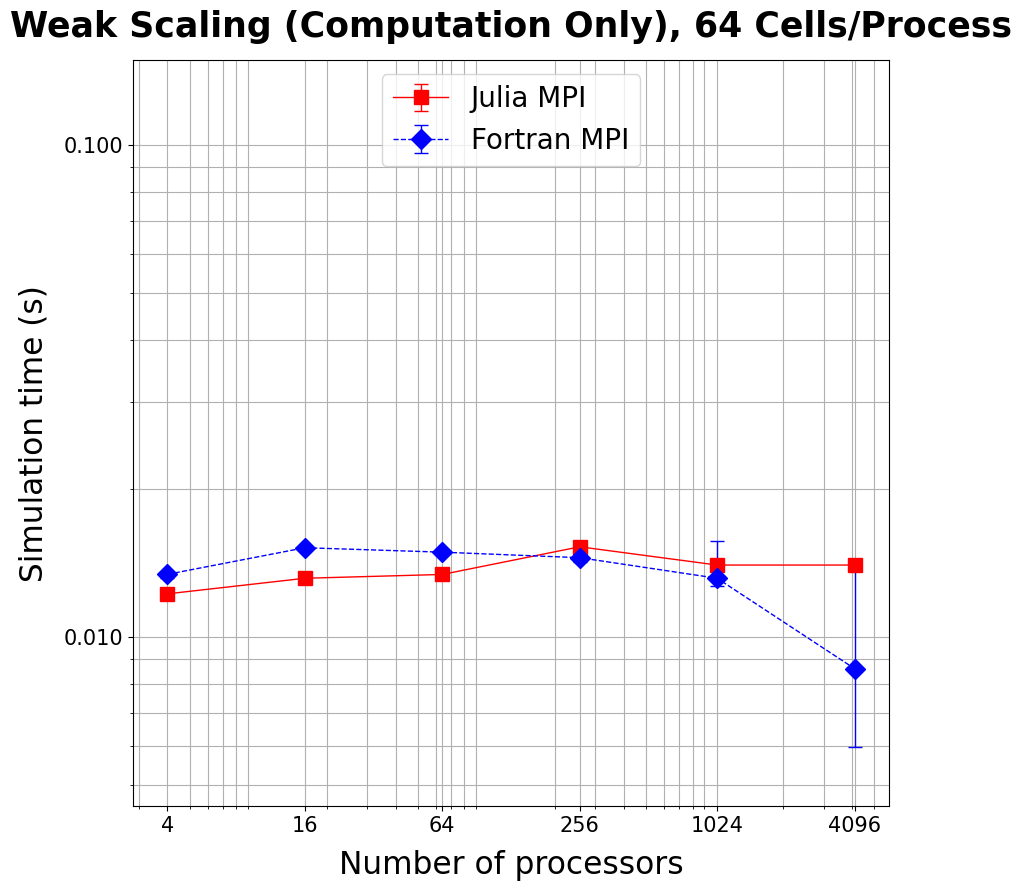

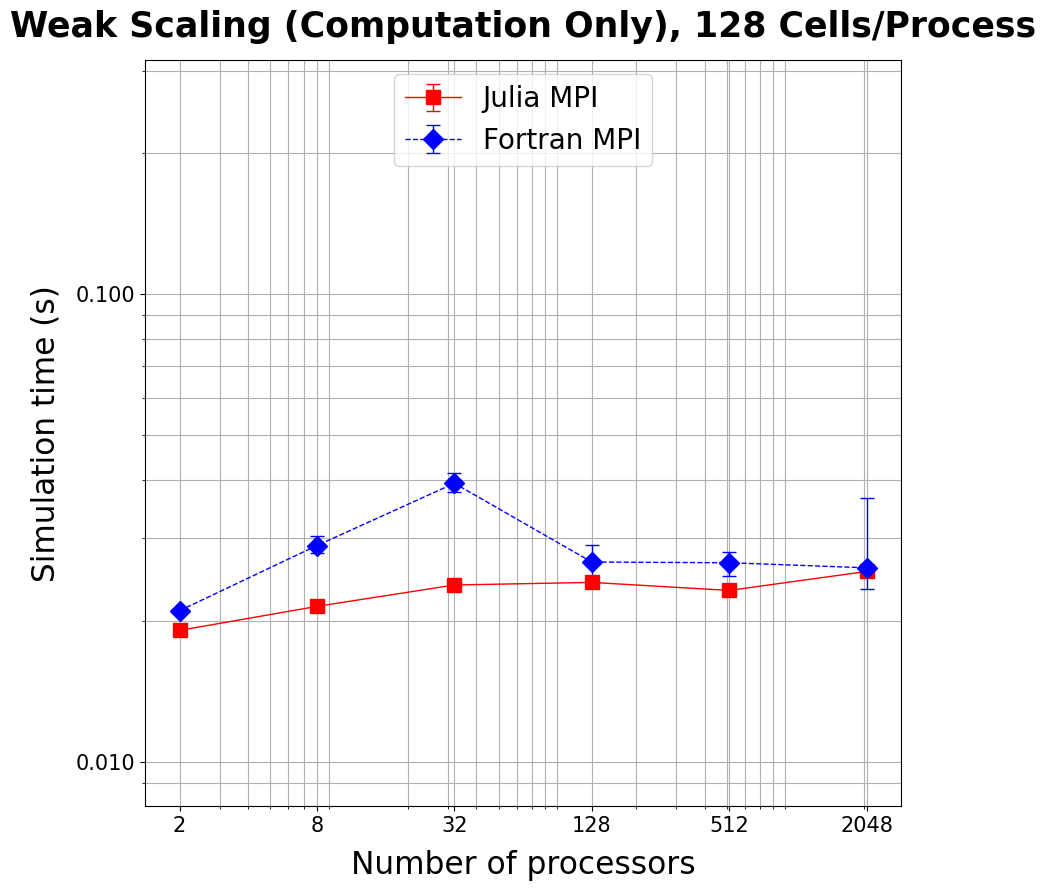

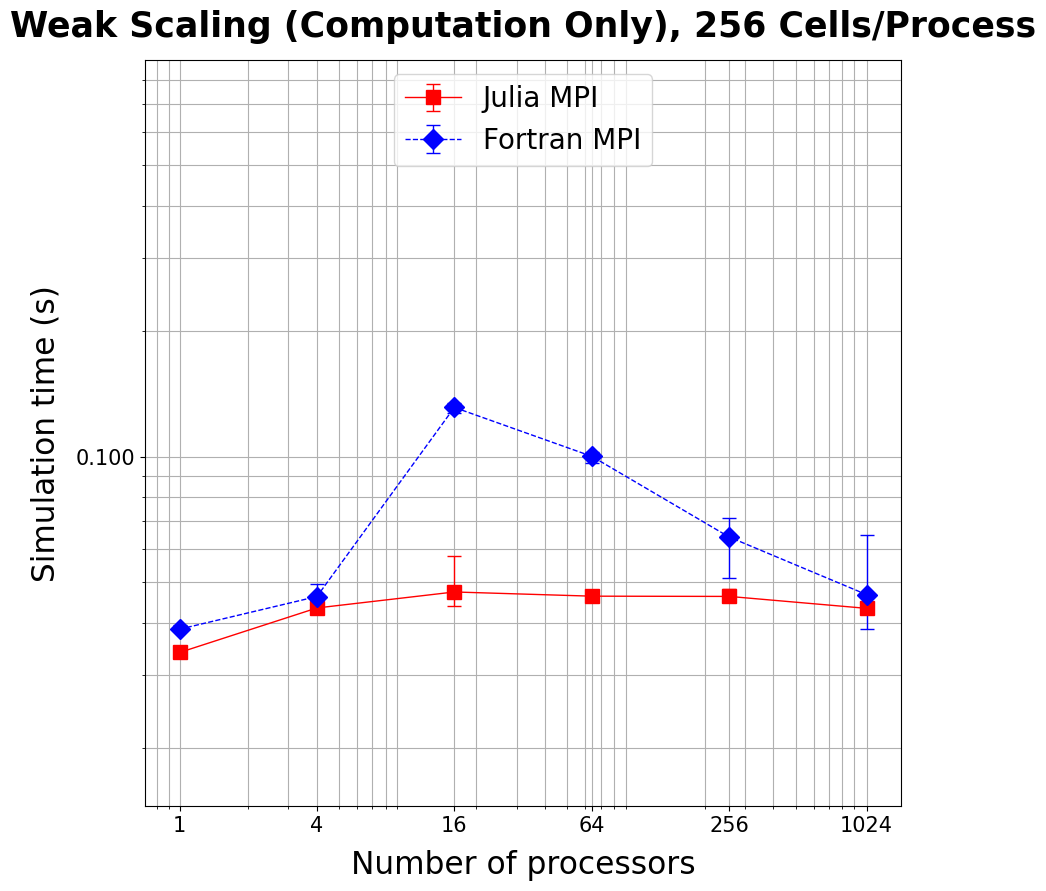

In [204]:
for which in ["total", "mpi", "comp"]
    weakscalingplot(which = which, resolutions = [16, 32, 64, 128, 256, 512], constlines = [64, 128, 256])
end

saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/constant_nprocs/total_64_and-gpu_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/constant_nprocs/mpi_64_and-gpu_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/constant_nprocs/comp_64_and-gpu_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevels100--2023-06-18T14:38:35.074.txt.pdf


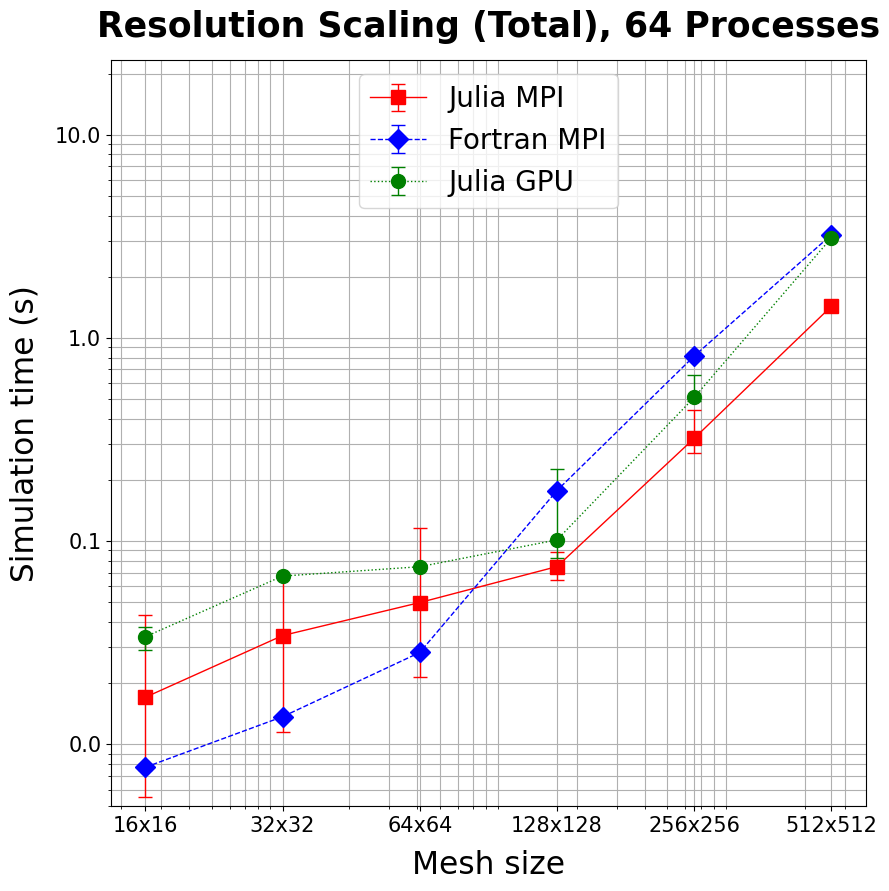

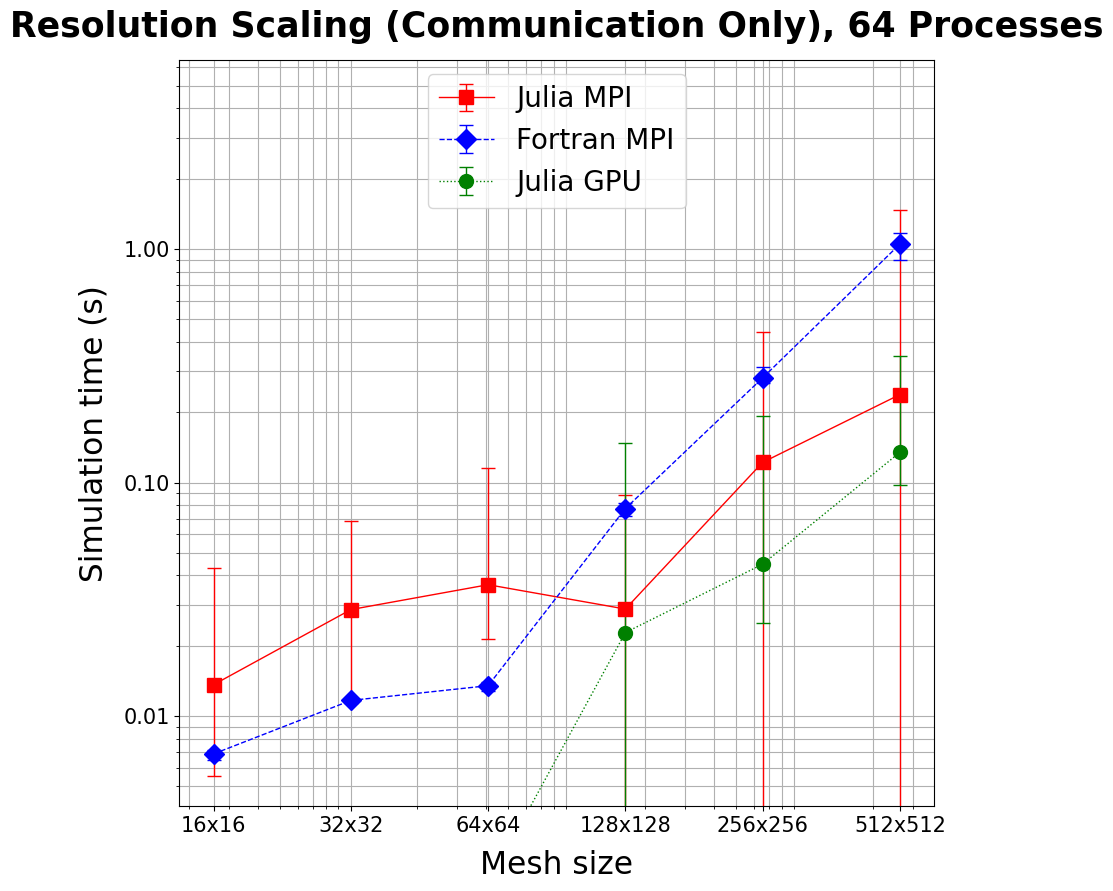

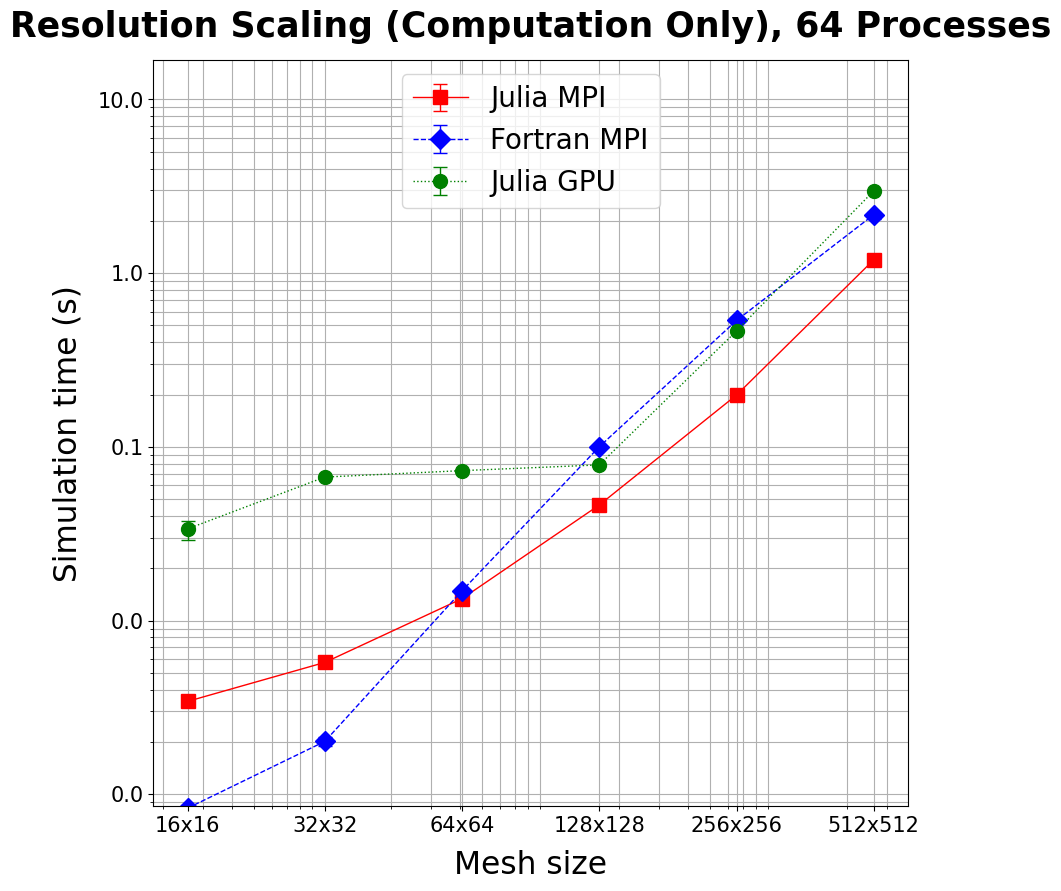

In [56]:
for which in ["total", "mpi", "comp"]
    weakscalingplot(which=which, resolutions = [16, 32, 64, 128, 256, 512], constlines = [64,], mode="constant_nprocs", gpu=true)
end

In [54]:
nCellsX = 256
jprocs = 4096
fprocs = 4096
fname = latestfile(JULIA_DATA_ROOT * "/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
df = DataFrame(CSV.File(fname))

runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
juliasimmean = 1/length(runs) * sum(Array(df[:,runs]), dims=2)
juliampimean = 1/length(mpis) * sum(Array(df[:,mpis]), dims=2)
juliameans = juliasimmean .+ juliampimean


fortranfnamesim = latestfile(FORTRAN_DATA_ROOT, x -> occursin("$fprocs", x) && occursin("$(nCellsX)x$(nCellsX)", x) && x[end-3:end] == ".txt" && occursin("runtime", x))
fortranfnamempi = latestfile(FORTRAN_DATA_ROOT, x -> occursin("$fprocs", x) && occursin("$(nCellsX)x$(nCellsX)", x)  && x[end-3:end] == ".txt" && occursin("halotime", x))
fortransimtiming = readdlm(fortranfnamesim, skipstart=8)
fortranmpitiming = readdlm(fortranfnamempi, skipstart=8)
fortransimmean = fortransimtiming[:,end] #./ 4
fortranmpimean = fortranmpitiming[:,end]
fortransimstd = dropdims( std(Array(fortransimtiming[:,2:end-1]), dims=2), dims=2)
fortranmpistd = dropdims( std(Array(fortranmpitiming[:,2:end-1]), dims=2), dims=2)
fortranprocs = fortransimtiming[:,1]

juliasimstd = std(Array(df[:,runs]), dims=2)
juliampistd = std(Array(df[:,mpis]), dims=2)

df

Row,procs,sim_time1,sim_time2,sim_time3,sim_time4,sim_time5,sim_time6,mpi_time1,mpi_time2,mpi_time3,mpi_time4,mpi_time5,mpi_time6,max_error,l2_error
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,11.3206,11.5749,11.3468,11.3508,11.2838,11.3219,0.0,0.0,0.0,0.0,0.0,0.0,0.000105101,2.35253e-5
2,2.0,5.52077,5.51047,5.5061,5.49189,5.44444,5.82095,2.75031,0.14382,0.111595,0.205846,0.365201,0.143344,0.000105101,3.30386e-5
3,4.0,2.73427,2.65982,2.65328,2.65581,2.65631,2.65959,3.59264,0.135327,0.0824391,0.0673102,0.0909821,0.114359,1.96094e-5,3.78619e-6
4,8.0,1.37598,1.39361,1.39092,1.39195,1.39015,1.39132,2.9108,0.0297822,0.4451,0.0290327,0.096377,0.303973,1.85902e-5,3.80209e-6
5,16.0,0.620092,0.618677,0.620225,0.619541,1.02775,0.607018,3.09266,0.102575,0.129952,0.146766,0.0964225,0.342845,5.13084e-5,1.13302e-5
6,32.0,0.328058,0.340445,0.347881,0.346626,0.347163,0.361922,2.99091,0.279983,0.0683716,0.165692,0.0350969,0.0729889,9.92513e-6,2.66895e-6
7,64.0,0.208361,0.1973,0.195393,0.200074,0.201133,0.200328,3.67747,0.242732,0.0755961,0.105565,0.0869688,0.0991226,1.24943e-5,3.16059e-6
8,128.0,0.0801327,0.0847307,0.0795518,0.0808173,0.0801713,0.0807418,3.07135,0.0304499,0.0295715,0.105542,0.322026,0.209198,0.00013979,4.42071e-5
9,256.0,0.0515061,0.0480749,0.0468511,0.045572,0.0455941,0.0450322,3.31191,0.0867046,0.0764338,0.0553621,0.0621843,0.0577267,0.00011976,3.86438e-5


In [59]:
DataFrame(fortransimtiming[end:-1:1,:], :auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,11.6274,11.306,11.2842,11.3394,11.4107,11.3147,11.5528,11.5843,11.6381,11.5997,11.4657
2,2.0,6.43239,6.41896,6.45276,6.48862,6.56703,6.49271,6.34856,6.48092,6.46053,6.43552,6.4578
3,4.0,4.11042,4.10938,4.08829,4.09659,4.09143,4.10853,4.11401,4.09319,4.13801,4.09462,4.10445
4,8.0,3.4052,3.40936,3.42613,3.41951,3.42525,3.41486,3.41174,3.41156,3.43618,3.44581,3.42056
5,16.0,3.1791,3.181,3.17052,3.18835,3.18409,3.21913,3.17429,3.17543,3.1963,3.21514,3.18833
6,32.0,1.61939,1.61937,1.61609,1.62715,1.62151,1.62259,1.62105,1.62223,1.63176,1.62682,1.6228
7,64.0,0.81474,0.81459,0.81148,0.8191,0.8168,0.81495,0.81318,0.81124,0.81402,0.81964,0.814974
8,128.0,0.40364,0.40419,0.40243,0.40151,0.40218,0.40159,0.40348,0.39994,0.40231,0.40292,0.402419
9,256.0,0.17613,0.17894,0.17743,0.17778,0.17845,0.17785,0.17866,0.17599,0.17686,0.17718,0.177527


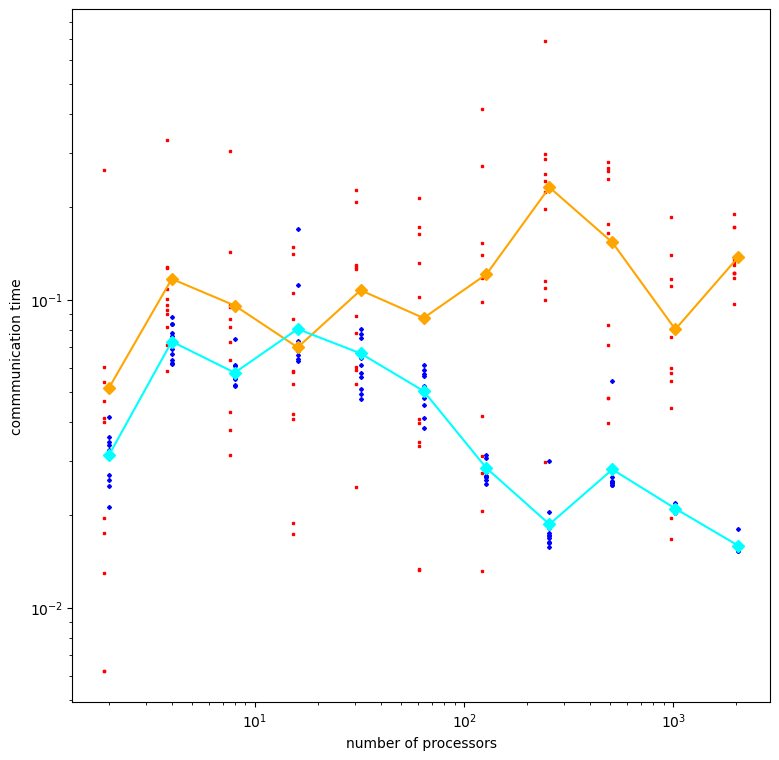

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,9))

ax.set_xscale("log")
ax.set_yscale("log")

for i in 1:length(mpis)
    mpi = mpis[i]
    ax.loglog(df.procs *0.95, df[:,mpi],               marker="s", linestyle="none", color="red",  markersize=2)
    ax.loglog(fortranmpitiming[:,1], fortranmpitiming[:,i+1], marker="D", linestyle="none", color="blue", markersize=2)
end

ax.loglog(df.procs, juliampimean, marker="D", color="orange")
ax.loglog(fortranmpitiming[:,1], fortranmpimean, marker="D", color="cyan")

ax.set_xlabel("number of processors")
ax.set_ylabel("commmunication time")
;